# Experimentación - DryGrEncoder



## 1. Obtención de datos



In [1]:
import torch
print(torch.__version__)

2.2.2


In [2]:
import torch.nn.functional as F
import pandas as pd
import seaborn as sns
import networkx as nx
sns.set_palette("coolwarm_r")
import matplotlib.pyplot as plt
import numpy as np


import os, sys

path = os.getcwd()

sys.path.insert(1, "/".join(path.split("/")[0:-1]))


from utils import powergrid

In [2]:
folder_path = "/home/TFM/code_dataset2/datos/Natural Oscillation"


In [3]:
loader = powergrid.PowerGridDatasetLoader(folder_path, problem="regression")
_,_,_ =loader.process()
limit = 300
#dataset_full = loader.get_dataset( target= 20, intro=300, step=20, limit=limit, one_ts_per_situation=False)

Processing:  row_214
Node:  0  not included, including...
Node:  1  not included, including...
Node:  2  not included, including...
Node:  3  not included, including...
Node:  4  not included, including...
Node:  5  not included, including...
Node:  6  not included, including...
Node:  7  not included, including...
Node:  8  not included, including...
Node:  9  not included, including...
Node:  10  not included, including...
Node:  11  not included, including...
Node:  12  not included, including...
Node:  13  not included, including...
Node:  14  not included, including...
Node:  15  not included, including...
Node:  16  not included, including...
Node:  17  not included, including...
Node:  18  not included, including...
Node:  19  not included, including...
Node:  20  not included, including...
Node:  21  not included, including...
Node:  22  not included, including...
Processing:  row_32
Processing:  row_57
Processing:  row_110
Processing:  row_248
Processing:  row_119
Processing: 

## Funciones auxiliares - entrenamiento

In [4]:
from utils import pygt_loader

try:
    from tqdm import tqdm
except ImportError:
    def tqdm(iterable):
        return iterable
import os
import torch
import torch.nn.functional as F
from utils.dygrae import DyGrEncoder
from sklearn.metrics import r2_score

from torch.optim.lr_scheduler import ReduceLROnPlateau
from utils.utils_graph import format_plot

from utils.trainer import TrainerModel
from utils import trainer
dtype = torch.float
device = torch.device("cpu")

In [5]:
from importlib import reload  # Python 3.4+
import utils.dygrae
dygrae = reload(utils.dygrae)


In [6]:
def reconstruir_predictions(predictions,real, n_target, situacion, n_div, n_nodes=23):
    
    temp = np.array(predictions).reshape(-1, n_nodes, n_target)
    temp2 =np.array(real).reshape(-1, n_nodes, n_target)
    if n_div != None:
        id_situacion = situacion*n_div 
        return n_div, np.concatenate([np.array(temp[id_situacion+i]) for i in range(n_div)], axis=1), np.concatenate([np.array(temp2[id_situacion+i]) for i in range(n_div)], axis=1)
    m = temp.shape[0]
    return m, np.concatenate([np.array(temp[situacion+i]) for i in range(m)], axis=1), np.concatenate([np.array(temp2[situacion+i]) for i in range(m)], axis=1)


In [7]:
def plot_training_and_eval_losses(train_losses, eval_losses, num_epochs, format_plot):
    epochs = range(1, num_epochs + 1)


    plt.figure(figsize=(12, 5), dpi=200)
    ax = plt.gca()

    sns.lineplot(x=epochs, y=train_losses, label='Training Loss')
    sns.lineplot(x=epochs, y=eval_losses, label='Evaluation Loss', color="royalblue")
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.set_title('Loss by Epoch')
    ax.legend()
    format_plot(ax) 
    plt.tight_layout()
    plt.show()

In [8]:
def plot_predictions(predictions, real, n_target, n_situation, n_div, problem):
    # Reconstruct predictions and true values
    m, preds, y_true = reconstruir_predictions(predictions, real, n_target, n_situation, n_div=n_div)
    
    n_plots = 23
    n_cols = 4
    n_rows = (n_plots + n_cols - 1) // n_cols  # Calculating number of rows

    fig, axs = plt.subplots(n_rows, n_cols, figsize=(15, 10), dpi=200)
    handles = []
    labels = []
    for i in range(n_plots):
        row = i // n_cols  # Calculate the row index
        col = i % n_cols   # Calculate the column index
        ax = axs[row, col]

        sns.lineplot(y=y_true[i], x=range(n_target * m), ax=ax, label='Real', legend=False, color="royalblue")
        sns.lineplot(y=preds[i], x=range(n_target * m), ax=ax, label='Predicciones', legend=False)
        if not handles:
            handles, labels = ax.get_legend_handles_labels()
        ax.set_title(f'Nodo {i+1}')
        format_plot(ax)
    
    # Add legend to the last plot
    #axs[n_rows - 1, n_cols - 2].legend(loc='upper right', bbox_to_anchor=(1.5, 0.95), frameon=True)
    fig.legend(handles, ['Real', 'Predicciones'], bbox_to_anchor=(0.95, 0.08),loc = 'lower right', fontsize=15)

    # Remove any unused subplots
    if n_plots < (n_rows * n_cols):
        for i in range(n_plots, (n_rows * n_cols)):
            fig.delaxes(axs.flatten()[i])

    # Adjust layout and add super title
    plt.suptitle(f'Predicciones y valores reales en {problem}, caso {n_situation}', fontsize=20)
    plt.tight_layout(pad=2)
    plt.show()

In [9]:
class RecurrentGCN(torch.nn.Module):
    def __init__(self, name, node_features, node_count, n_target, num_conv=1,  num_lstm=1, aggr="mean"):
        self.name  =name
        self.n_nodes = node_count
        self.n_target = n_target
        self.n_features = node_features
        super(RecurrentGCN, self).__init__()
        self.recurrent = dygrae.DyGrEncoder(conv_out_channels=100, conv_num_layers=num_conv, conv_aggr=aggr, lstm_out_channels=self.n_features, lstm_num_layers=num_lstm)
        self.linear = torch.nn.Linear(self.n_features, n_target)

    def forward(self, x, edge_index, edge_weight, h_0, c_0):
        h, h_0, c_0 = self.recurrent(x, edge_index, edge_weight, h_0, c_0)
        h = F.relu(h)
        h = self.linear(h)
        return h, h_0, c_0


In [10]:
def eval(model, dataloader, h):
    model.eval()
    loss_eval, r2_eval = [], []
    h, c = None, None
    for time, snapshot in enumerate(dataloader['val']):
        x = snapshot.x  # [num_nodes, num_time_steps] -> [23, 100]
        edge_index = snapshot.edge_index.permute(2, 1, 0)  # [2, num_edges, num_time_steps]-> [2, 30, 100]
        edge_attr = snapshot.edge_attr.permute(1, 0, 2)  # [num_edges, num_time_steps, num_edge_features] -> [30, 100, 2]
        y = snapshot.y

        y_hat, h, c = model(x, edge_index[:,:,0],edge_attr, h, c)
        loss = F.mse_loss(y_hat, y).item()
        r2_eval.append(r2_score(y.cpu(), y_hat.cpu()))
        loss_eval.append(loss)
    return loss_eval, r2_eval




def train(model,dataloader, num_early_stop, num_epochs, lr ):

    print("\n==================== TRAIN INFO ===================\n")

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    model.to(device)
    lr_schedule = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, min_lr=0.001)
    early_stop_counter = 0
    best_eval_r2score = -100.0
    best_eval_loss = float('inf')
    losses = []
    eval_losses, r2scores = [], []
    is_best = False

    for epoch in range(num_epochs):
        model.train()
        cost = 0
        h,c=None, None
        for time, snapshot in enumerate(dataloader['train']):
            x = snapshot.x  # [num_nodes, num_time_steps] -> [23, 100]
            edge_index = snapshot.edge_index.permute(2, 1, 0)  # [2, num_edges, num_time_steps]-> [2, 30, 100]
            edge_attr = snapshot.edge_attr.permute(1, 0, 2)  # [num_edges, num_time_steps, num_edge_features] -> [30, 100, 2]
            y = snapshot.y

            y_hat, h, c = model(x, edge_index[:,:,0],edge_attr, h, c)
            cost = cost + F.mse_loss(y_hat, y)
        
        cost = cost / (time+1)
        cost.backward(retain_graph=False)
        losses.append(cost.item())
        optimizer.step()
        optimizer.zero_grad()
            
        train_loss = cost

    
        with torch.no_grad():
            e_loss_batch, r2_loss_batch = eval(model, dataloader, h)
            eval_loss = torch.FloatTensor(e_loss_batch).mean().item()
            eval_r2score = torch.FloatTensor(r2_loss_batch).mean().item()
            eval_losses.append(e_loss_batch)
            r2scores.append(r2_loss_batch)
        
        print(f"Epoch {epoch + 1}/{num_epochs} | "
            f"Train Loss: {train_loss:.4f} | "
            f"Eval Loss: {eval_loss:.4f} | "
            f"Eval R2: {eval_r2score:.4f} | "
            f"LR: {optimizer.param_groups[0]['lr']:.6f}")
        
        if num_early_stop > 0:
            if eval_loss <= best_eval_loss:
                best_eval_loss = eval_loss
                early_stop_counter = 0
            else:
                early_stop_counter += 1
            if epoch > num_epochs / 2 and early_stop_counter > num_early_stop:
                print("Early stopping triggered.")
                break
            
        if lr_schedule:
            lr_schedule.step(eval_loss)

        if best_eval_r2score < eval_r2score:
            is_best = True
            best_eval_r2score = eval_r2score
        recording = {"epoch": epoch, "is_best": str(is_best)}
    print("\nTraining completed.")
    return losses, eval_losses, r2scores, h
    


def test(model, dataloader, h):
    
    print("\n==================== TEST INFO ===================\n")
    
    model.eval()
    predictions = []
    real =[]
    losses_tst, r2score_tst = [], []
    h,c=None, None
    for time, snapshot in enumerate(dataloader['test']):
        x = snapshot.x  # [num_nodes, num_time_steps] -> [23, 100]
        edge_index = snapshot.edge_index.permute(2, 1, 0)  # [2, num_edges, num_time_steps]-> [2, 30, 100]
        edge_attr = snapshot.edge_attr.permute(1, 0, 2)  # [num_edges, num_time_steps, num_edge_features] -> [30, 100, 2]
        y = snapshot.y

        y_hat, h, c = model(x, edge_index[:,:,0],edge_attr, h, c)
        loss = F.mse_loss(y_hat, y).item()


        preds = y_hat.view(model.n_nodes, model.n_target)
        real.append(y.view(model.n_nodes, model.n_target).cpu())
        predictions.append(preds.cpu().detach().numpy())
        r2score_tst.append(r2_score(y.detach().cpu(), y_hat.detach().cpu()))
        losses_tst.append(loss)
    test_loss = torch.tensor(losses_tst).mean().item()
    test_r2score = np.mean(r2score_tst)

    print(f"Test_loss:{test_loss:.4f}, Test_r2:{test_r2score:.4f}")
    return r2score_tst, losses_tst, predictions, real

In [11]:
import itertools


def entrenar_y_evaluar_modelos(param_grid, n_features, n_nodes, n_target, dataloader, num_early_stop, num_epochs, lr):
    """
    Entrena y evalúa modelos con diferentes combinaciones de hiperparámetros, y devuelve el mejor modelo,
    los mejores parámetros y un DataFrame con los resultados.

    Args:
        param_grid (dict): Diccionario con listas de valores de los hiperparámetros a probar.
        n_features (int): Número de características del nodo.
        n_nodes (int): Número de nodos.
        n_target (int): Número de objetivos.
        dataloader (object): Objeto que proporciona los datos para entrenamiento y evaluación.
        num_early_stop (int): Número de épocas para detenerse tempranamente si no hay mejora.
        num_epochs (int): Número de épocas para entrenar.
        lr (float): Tasa de aprendizaje.

    Returns:
        mejor_modelo (object): El mejor modelo entrenado.
        mejores_parametros (tuple): Los mejores parámetros (aggr, conv, lstm).
        resultados_gt (pd.DataFrame): DataFrame con los resultados de todas las combinaciones de hiperparámetros.
    """
    resultados_list = []

    #Vamos a guardar el mejor modelo
    mejor_loss_test = float('inf')
    mejor_modelo = None
    mejores_parametros = None


    for aggr, conv, lstm in tqdm(list(itertools.product(param_grid["aggr"], param_grid["conv"], param_grid["lstm"]))):
        model = RecurrentGCN("DyGrEncoder", node_features=n_features, node_count=n_nodes, n_target=n_target, num_conv=conv, num_lstm=lstm, aggr=aggr)
        losses, eval_losses, r2scores, h = train(model, dataloader, num_early_stop, num_epochs, lr)
        r2score_tst, losses_tst, _, _ = test(model, dataloader, h)

        # Añade los resultados a la lista
        resultados_list.append({
            "Aggr": aggr,
            "Conv": conv,
            "LSTM": lstm,
            "loss_final": losses[-1],
            "r2_eval_final": r2scores[-1],
            "loss_eval_final": np.mean(eval_losses[-1]),
            "r2_test": np.mean(r2score_tst),
            "loss_test": np.mean(losses_tst)
        })

        if np.mean(losses_tst) < mejor_loss_test:
            mejor_loss_test = np.mean(losses_tst)
            mejor_modelo = model
            mejores_parametros = (aggr, conv, lstm)

        print("Parámetros: ", aggr, conv, lstm)
        print("Resultados: ", resultados_list[-1])

    resultados_gt = pd.DataFrame(resultados_list)

    return mejor_modelo, mejores_parametros, resultados_gt


## Prueba - predicción por tipos

### Gen trip

In [12]:
problem = "gen_trip"
dataset_gt, situations_gt = loader.get_dataset( target= 20, intro=100, step=20, one_ts_per_situation=False, start = 1, type=problem)



Number of situations:  549
Number of timestamps:  800
Number of situations of the selected type:  184


In [13]:
n_div_gt = loader.div

#### Sencilla 

In [14]:
n_nodes =dataset_gt.features[0].shape[0]
n_target = dataset_gt.targets[0].shape[1]
n_features = dataset_gt[0].x.shape[1]
embedding_dim =5


==================== DATASET INFO ===================

Train dataset: 4350
Validation dataset: 930
Test dataset: 942

==================== TRAIN INFO ===================

Epoch 1/30 | Train Loss: 1.0952 | Eval Loss: 0.5714 | Eval R2: -254.6524 | LR: 0.010000
Epoch 2/30 | Train Loss: 0.5824 | Eval Loss: 0.1249 | Eval R2: -39.6394 | LR: 0.010000
Epoch 3/30 | Train Loss: 0.1229 | Eval Loss: 0.1905 | Eval R2: -78.0969 | LR: 0.010000
Epoch 4/30 | Train Loss: 0.1822 | Eval Loss: 0.1455 | Eval R2: -54.8575 | LR: 0.010000
Epoch 5/30 | Train Loss: 0.1366 | Eval Loss: 0.0968 | Eval R2: -28.5756 | LR: 0.010000
Epoch 6/30 | Train Loss: 0.0913 | Eval Loss: 0.1027 | Eval R2: -30.3844 | LR: 0.010000
Epoch 7/30 | Train Loss: 0.1012 | Eval Loss: 0.1108 | Eval R2: -34.0645 | LR: 0.010000
Epoch 8/30 | Train Loss: 0.1109 | Eval Loss: 0.0974 | Eval R2: -27.5874 | LR: 0.010000
Epoch 9/30 | Train Loss: 0.0968 | Eval Loss: 0.0948 | Eval R2: -26.3884 | LR: 0.001000
Epoch 10/30 | Train Loss: 0.0940 | Eval Loss

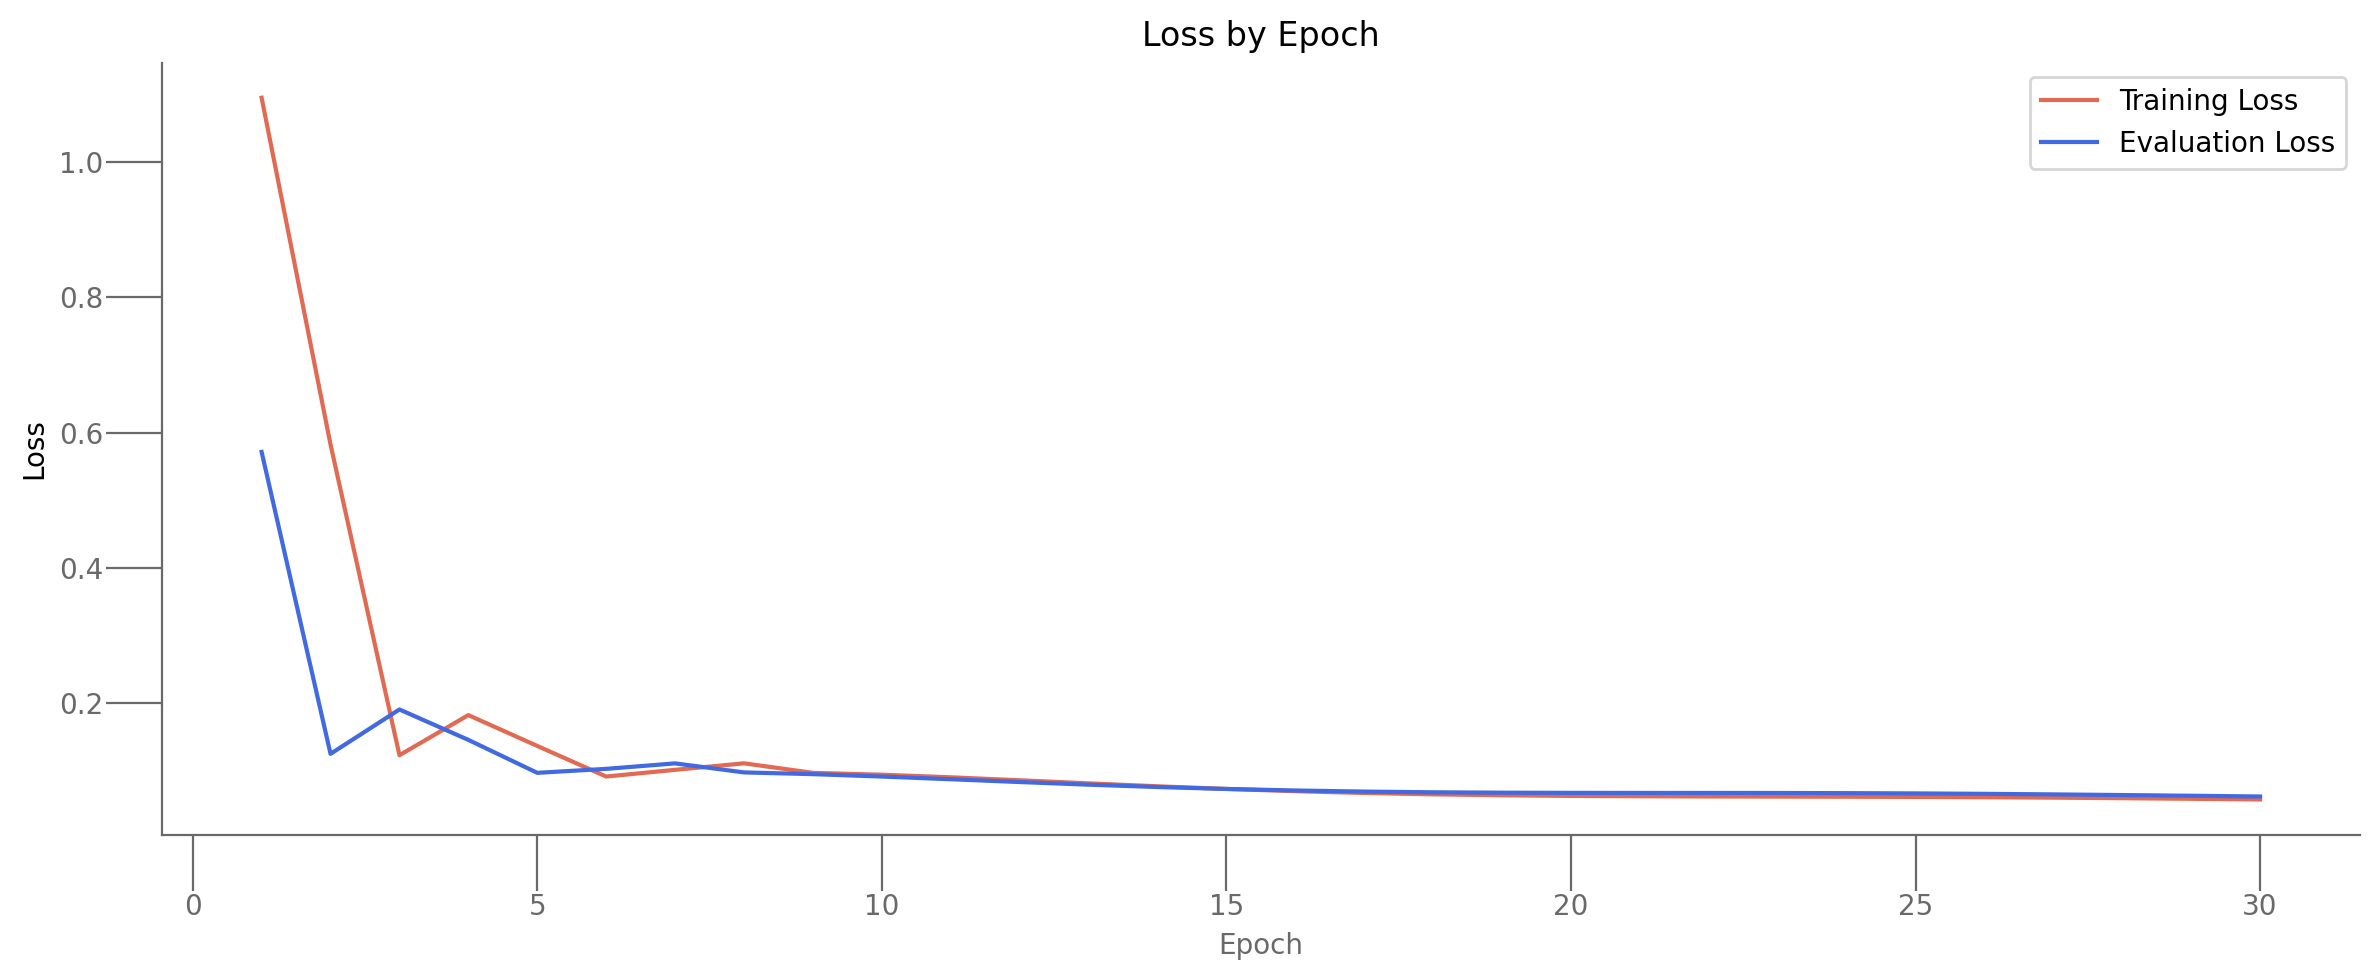


==================== TEST INFO ===================

Test_loss:0.0579, Test_r2:-15.0950


In [15]:
dataloader_params2 = {
            "batch_size": 5,
            "data_split_ratio": [0.7, 0.15, 0.15],
            "seed": 42,
            "keep_same": True,
            "use_batch":False
        }
dataloader_gt = trainer.train_test_val_split(dataset_gt, 
                                          batch_size=dataloader_params2["batch_size"], 
                                          data_split_ratio=dataloader_params2["data_split_ratio"], 
                                          random_seed=dataloader_params2["seed"], 
                                          keep_same=dataloader_params2["keep_same"], 
                                          use_batch=dataloader_params2["use_batch"])


num_early_stop = 0
num_epochs = 30
lr = 0.01

model = RecurrentGCN("DyGrEncoder",node_features= n_features, node_count=n_nodes, n_target=n_target, num_conv=1, num_lstm=1, aggr="add")

losses,eval_losses, r2scores, h = train(model, dataloader_gt, num_early_stop, num_epochs, lr)
plot_training_and_eval_losses(np.array(losses), np.array(eval_losses).mean(axis=1), num_epochs, format_plot)
losses_tst, r2score_tst, predictions, real = test(model, dataloader_gt, h)


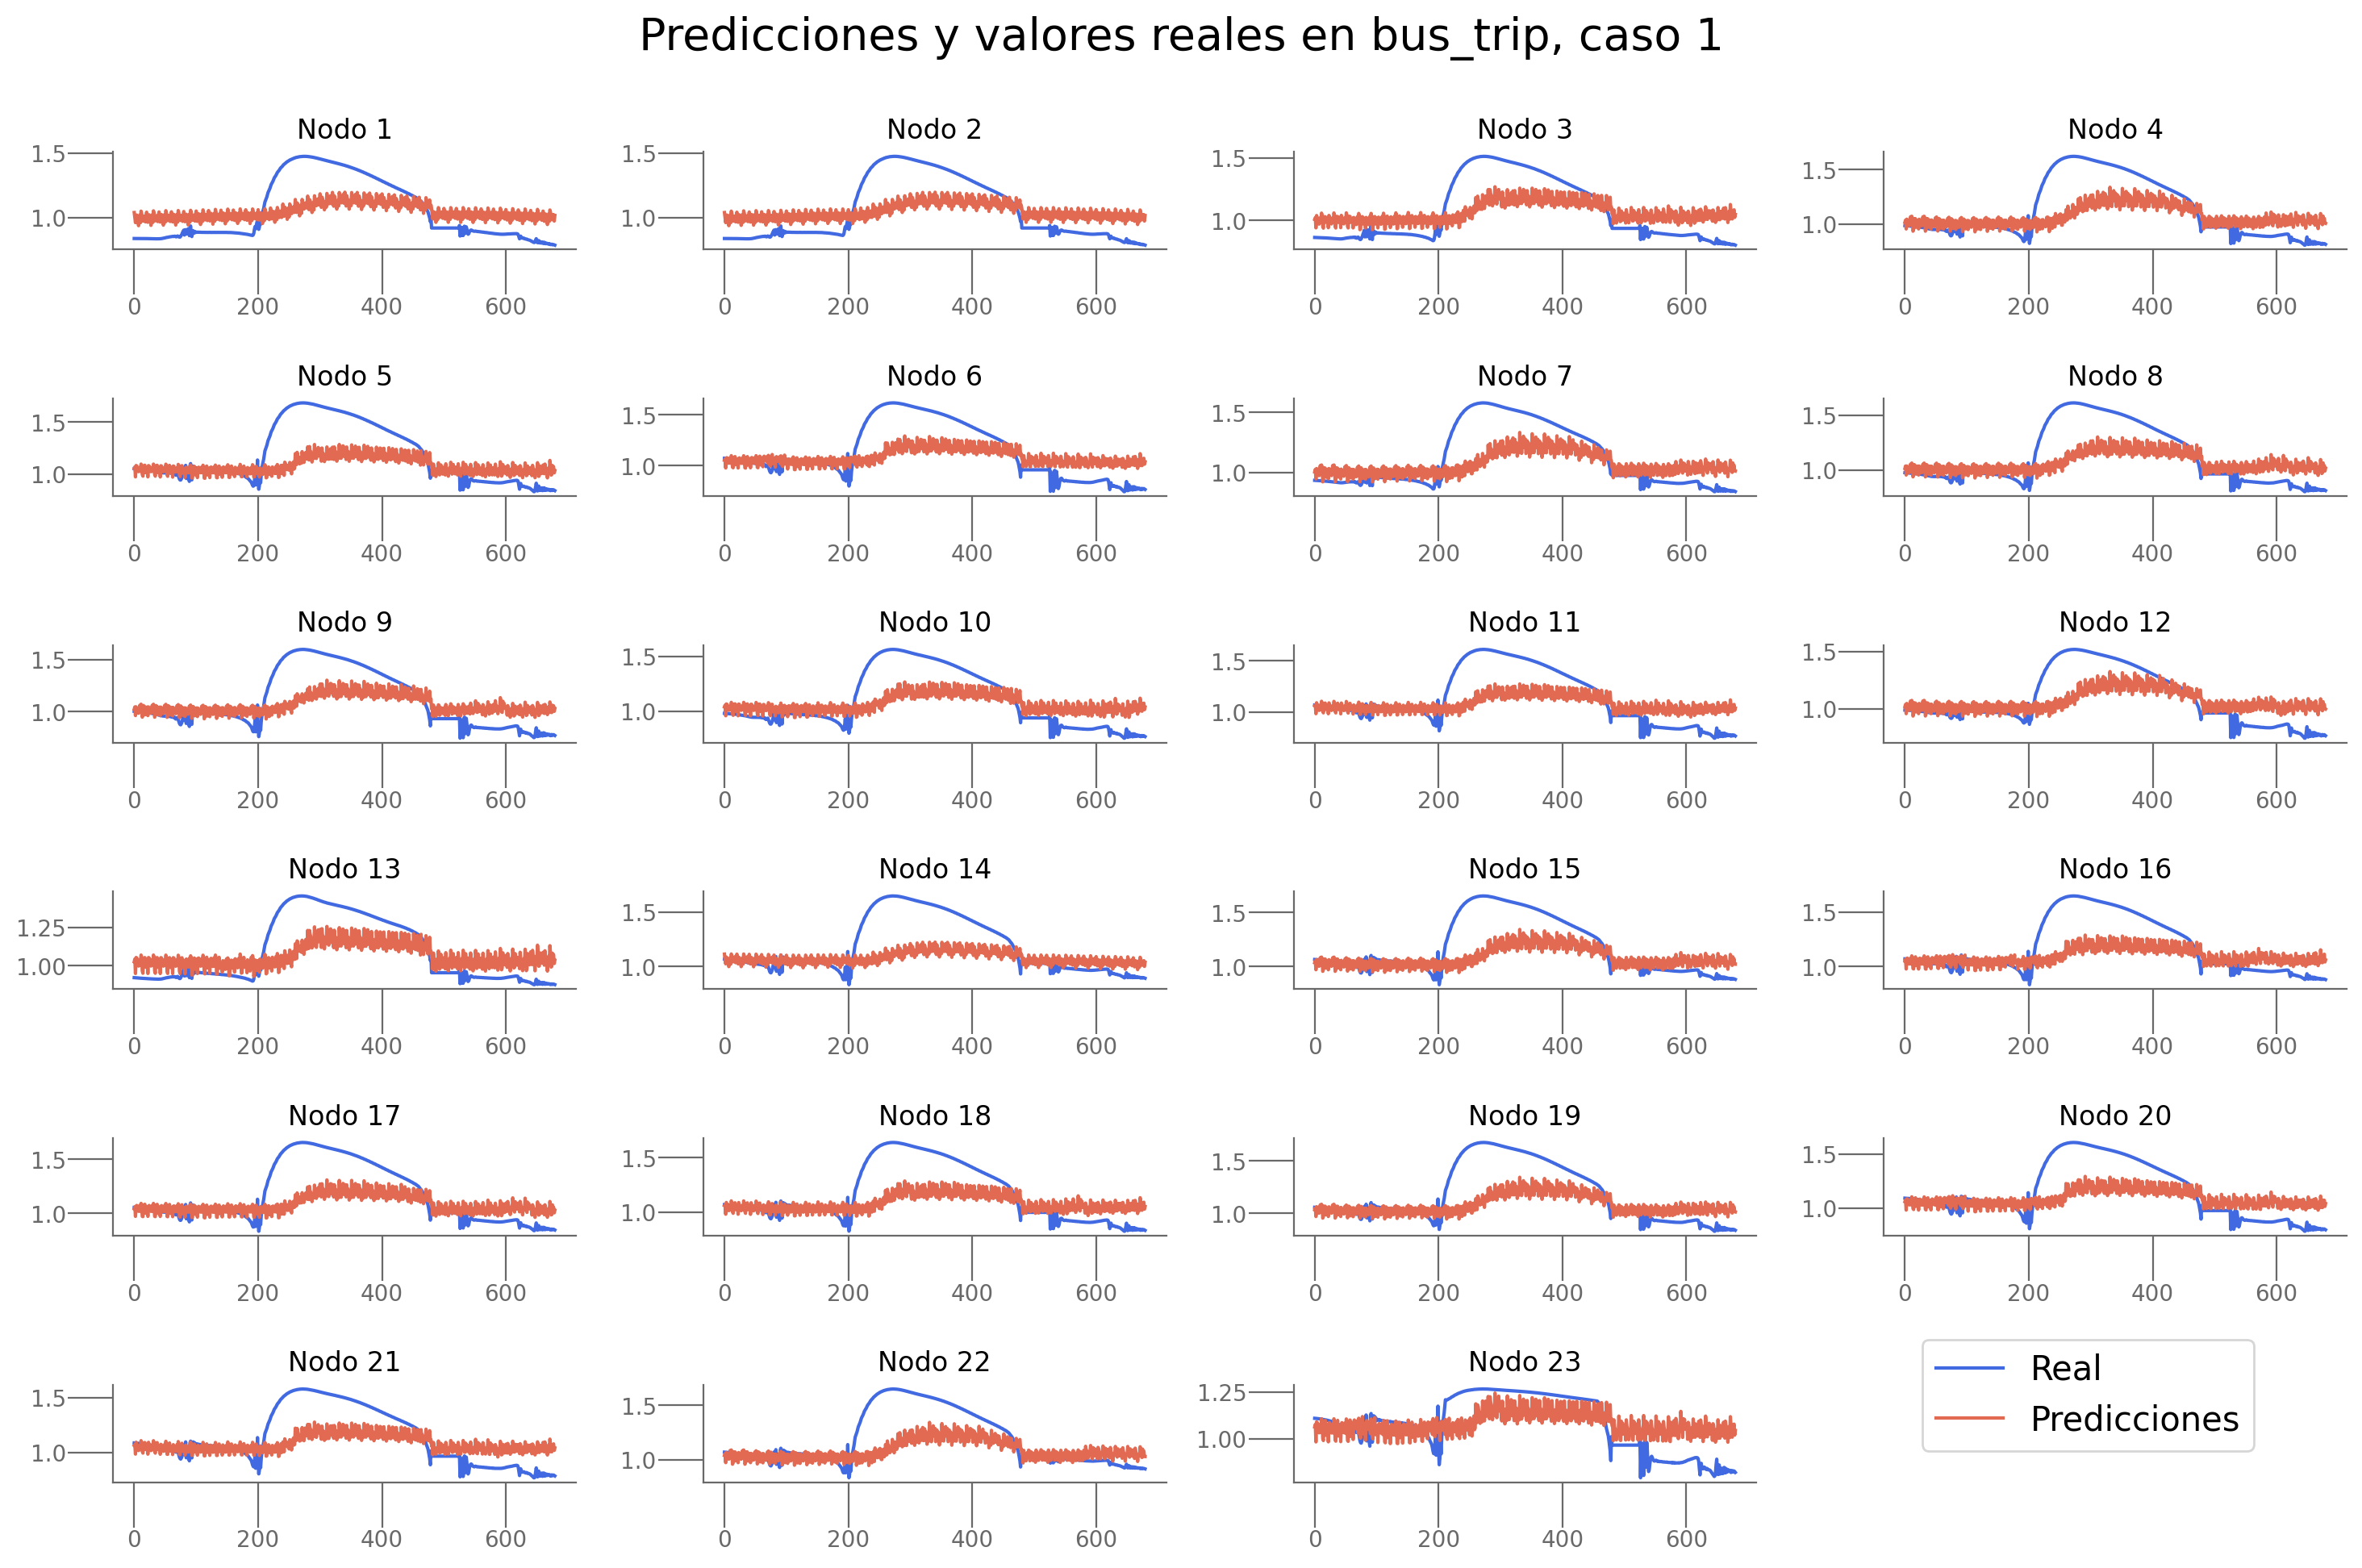

In [24]:
plot_predictions(predictions, real, n_target, 1, n_div_gt, problem)

#### Ajuste de parámetros 

In [47]:
param_grid = {
    "aggr": ["add", "mean"],
    "conv": [1,2],
    "lstm": [1,2]
}

modelo_gt,params_gt, resultados_gt = entrenar_y_evaluar_modelos(param_grid, n_features, n_nodes, n_target, dataloader_gt, num_early_stop, num_epochs, lr)

  0%|          | 0/8 [00:00<?, ?it/s]


==================== TRAIN INFO ===================

Epoch 1/30 | Train Loss: 1.1512 | Eval Loss: 0.6154 | Eval R2: -276.3333 | LR: 0.010000
Epoch 2/30 | Train Loss: 0.6282 | Eval Loss: 0.1641 | Eval R2: -59.2778 | LR: 0.010000
Epoch 3/30 | Train Loss: 0.1605 | Eval Loss: 0.2040 | Eval R2: -84.8422 | LR: 0.010000
Epoch 4/30 | Train Loss: 0.1975 | Eval Loss: 0.1235 | Eval R2: -43.1410 | LR: 0.010000
Epoch 5/30 | Train Loss: 0.1166 | Eval Loss: 0.0858 | Eval R2: -22.7125 | LR: 0.010000
Epoch 6/30 | Train Loss: 0.0820 | Eval Loss: 0.0948 | Eval R2: -26.6046 | LR: 0.010000
Epoch 7/30 | Train Loss: 0.0938 | Eval Loss: 0.0984 | Eval R2: -28.5702 | LR: 0.010000
Epoch 8/30 | Train Loss: 0.0982 | Eval Loss: 0.0869 | Eval R2: -23.6392 | LR: 0.010000
Epoch 9/30 | Train Loss: 0.0856 | Eval Loss: 0.0850 | Eval R2: -22.8228 | LR: 0.001000
Epoch 10/30 | Train Loss: 0.0835 | Eval Loss: 0.0825 | Eval R2: -21.7267 | LR: 0.001000
Epoch 11/30 | Train Loss: 0.0807 | Eval Loss: 0.0797 | Eval R2: -20.4830 |

 12%|█▎        | 1/8 [19:45<2:18:17, 1185.33s/it]

{'Aggr': 'add', 'Conv': 1, 'LSTM': 1, 'loss_final': 0.04928940534591675, 'r2_eval_final': [-23.318929377505558, -15.709176118203596, -2.98065384056196, -3.8148763734027016, -2.6032041407081907, -11.069442992084188, -7.646175527528859, -9.779837841280177, -12.627891652379912, -11.136406504980783, -8.882261797008228, -5.563681320320372, -2.6515228429141393, -1.2176140389527539, -0.5667548879963792, -0.6428800017575089, -1.080644667031356, -5.65633690433136, -38.19366906879422, -34.070315097226725, -19.770887754278025, -16.60461481427875, -12.508236425980353, -9.959755494333681, -8.21901164197733, -6.076548589311588, -3.5950494382014235, -0.9602594421886552, -5.409950780132256, -52.4428806669399, -28.714138588586316, -28.21385037199555, -24.184430378873408, -19.009039999347756, -14.482339568684788, -11.30539722374573, 0.03846667769099676, 0.08143338312963744, 0.04907474463057701, 0.03602207876118678, -0.05062006983429529, -0.3752769469676012, -0.7392794915490064, -2.9282619735747906, -2.9

: 

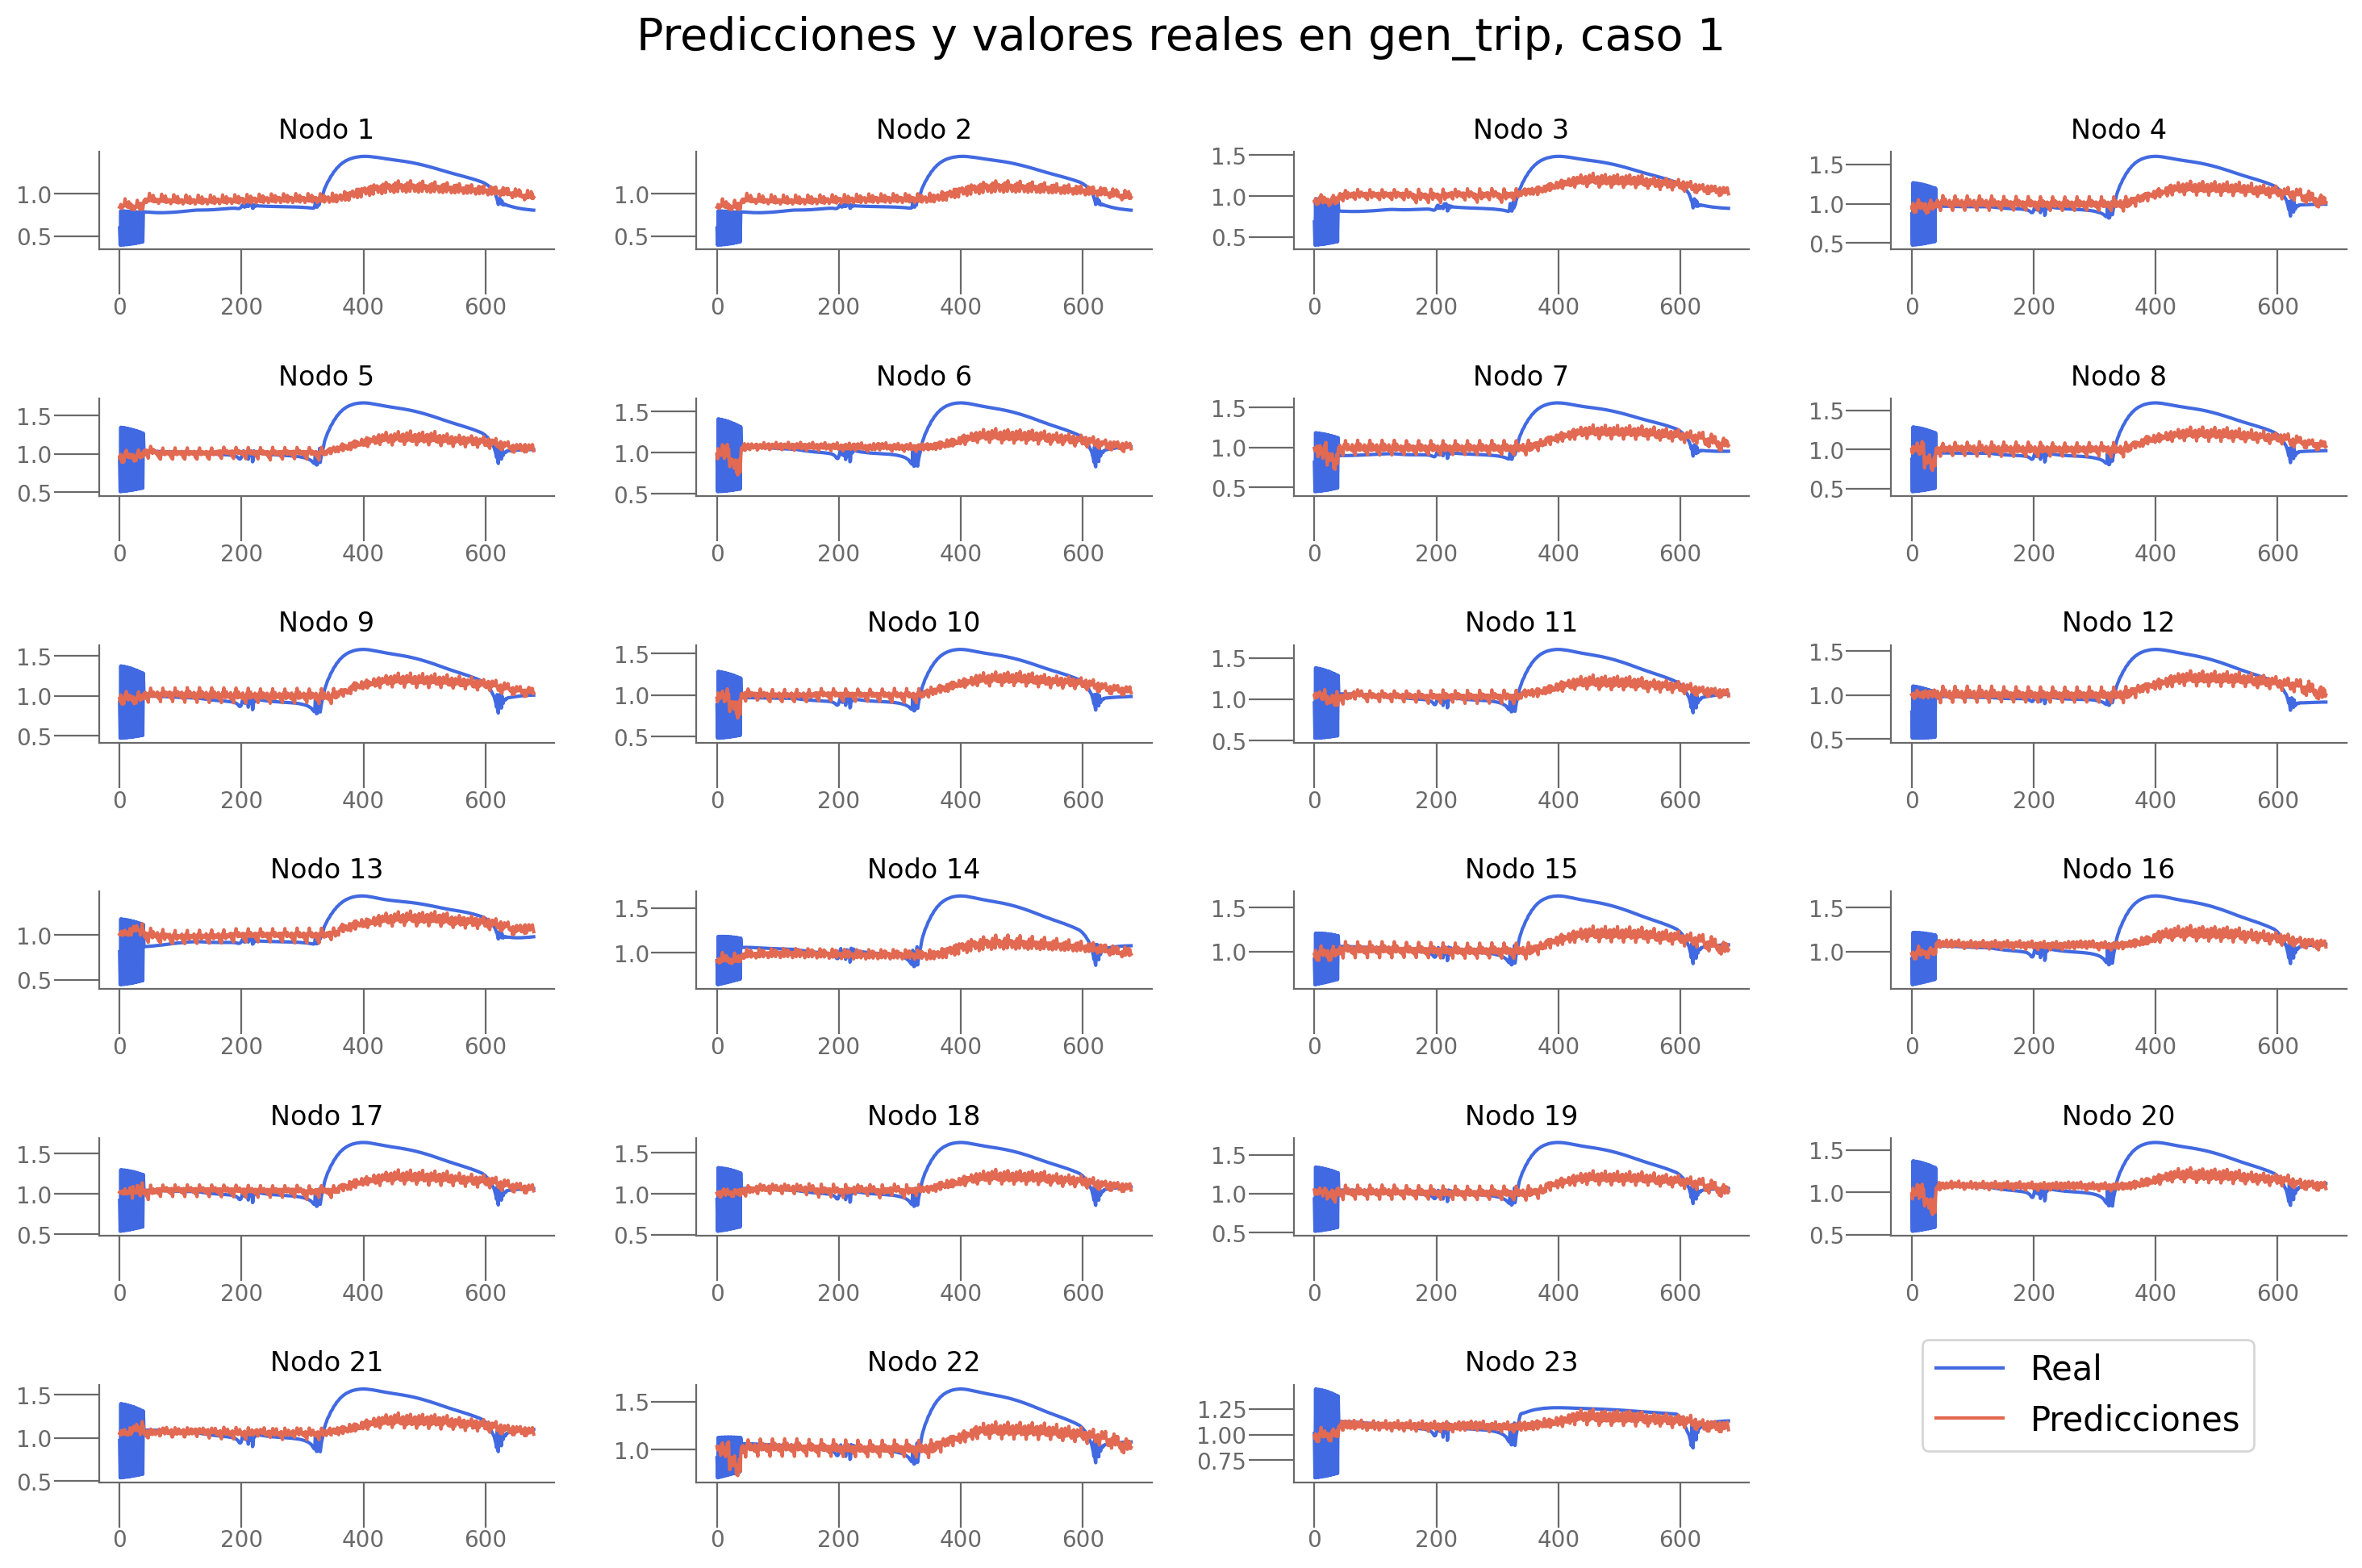

In [ ]:
plot_predictions(predictions, real, n_target, 1, n_div_gt, problem)

### Bus trip

In [25]:
problem = "bus_trip"
dataset_bt, situations_bt = loader.get_dataset( target= 20, intro=100, step=20, one_ts_per_situation=False, start = 1, type=problem)




Number of situations:  549
Number of timestamps:  800
Number of situations of the selected type:  86


In [26]:
n_div_bt = loader.div

#### Sencilla 

In [27]:
n_nodes =dataset_bt.features[0].shape[0]
n_target = dataset_bt.targets[0].shape[1]
n_features = dataset_bt[0].x.shape[1]
embedding_dim =5


==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 430

==================== TRAIN INFO ===================

Epoch 1/30 | Train Loss: 1.0047 | Eval Loss: 0.4807 | Eval R2: -13.6091 | LR: 0.010000
Epoch 2/30 | Train Loss: 0.5349 | Eval Loss: 0.1067 | Eval R2: -2.0118 | LR: 0.010000
Epoch 3/30 | Train Loss: 0.1090 | Eval Loss: 0.2048 | Eval R2: -6.0392 | LR: 0.010000
Epoch 4/30 | Train Loss: 0.1845 | Eval Loss: 0.1262 | Eval R2: -3.2557 | LR: 0.010000
Epoch 5/30 | Train Loss: 0.1146 | Eval Loss: 0.0726 | Eval R2: -1.1042 | LR: 0.010000
Epoch 6/30 | Train Loss: 0.0735 | Eval Loss: 0.0763 | Eval R2: -0.9768 | LR: 0.010000
Epoch 7/30 | Train Loss: 0.0875 | Eval Loss: 0.0777 | Eval R2: -0.9775 | LR: 0.010000
Epoch 8/30 | Train Loss: 0.0914 | Eval Loss: 0.0624 | Eval R2: -0.5645 | LR: 0.010000
Epoch 9/30 | Train Loss: 0.0738 | Eval Loss: 0.0480 | Eval R2: -0.2663 | LR: 0.010000
Epoch 10/30 | Train Loss: 0.0553 | Eval Loss: 0.0483 

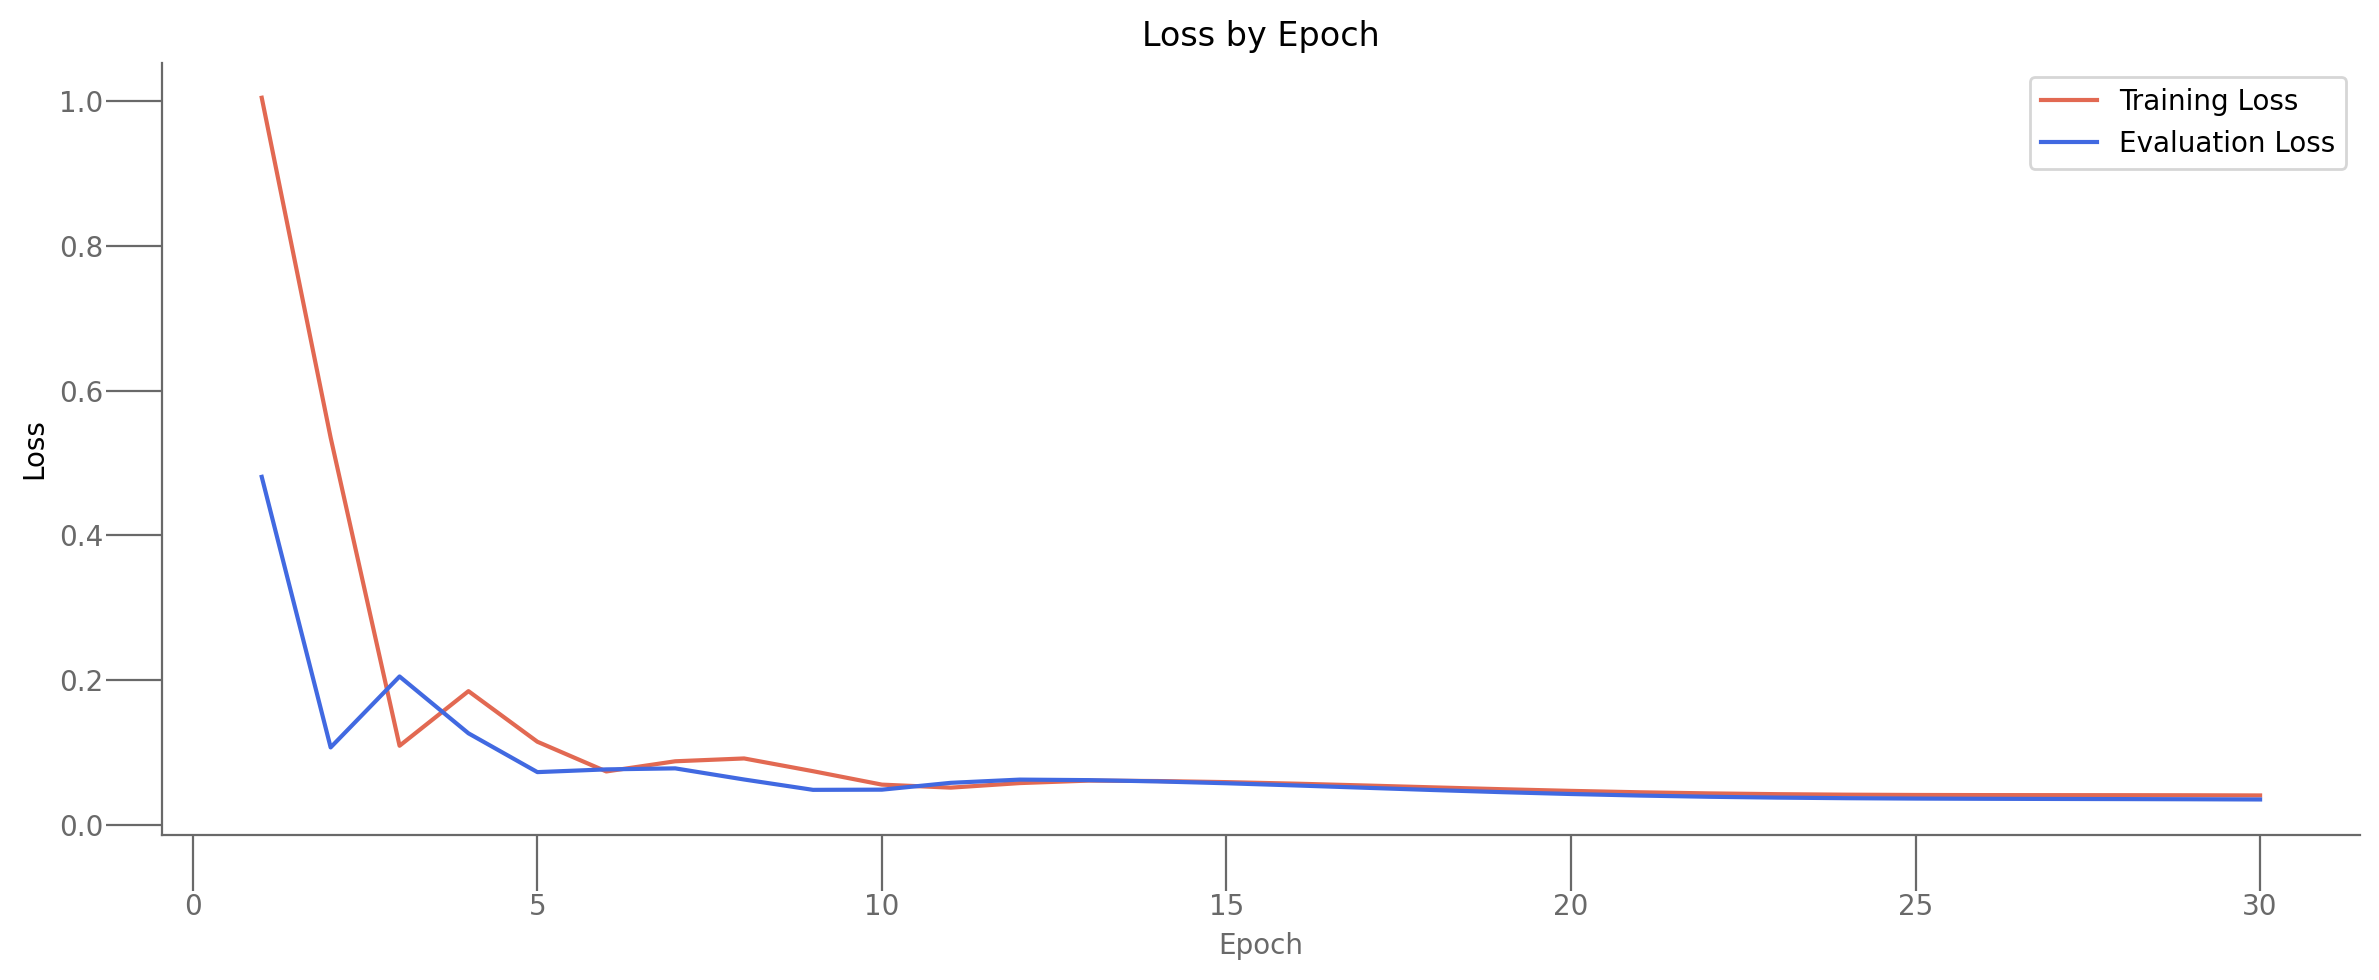


==================== TEST INFO ===================

Test_loss:0.0453, Test_r2:-0.0974


In [28]:

dataloader_bt = trainer.train_test_val_split(dataset_bt, 
                                          batch_size=dataloader_params2["batch_size"], 
                                          data_split_ratio=dataloader_params2["data_split_ratio"], 
                                          random_seed=dataloader_params2["seed"], 
                                          keep_same=dataloader_params2["keep_same"], 
                                          use_batch=dataloader_params2["use_batch"])
model_bt = RecurrentGCN("DyGrEncoder",node_features= n_features, node_count=n_nodes, n_target=n_target, aggr="add")


num_early_stop = 0
num_epochs = 30
lr = 0.01


losses,eval_losses, r2scores, h = train(model_bt, dataloader_bt, num_early_stop, num_epochs, lr)
plot_training_and_eval_losses(np.array(losses), np.array(eval_losses).mean(axis=1), num_epochs, format_plot)
losses_tst, r2score_tst, predictions_bt, real_bt = test(model_bt, dataloader_bt, h)


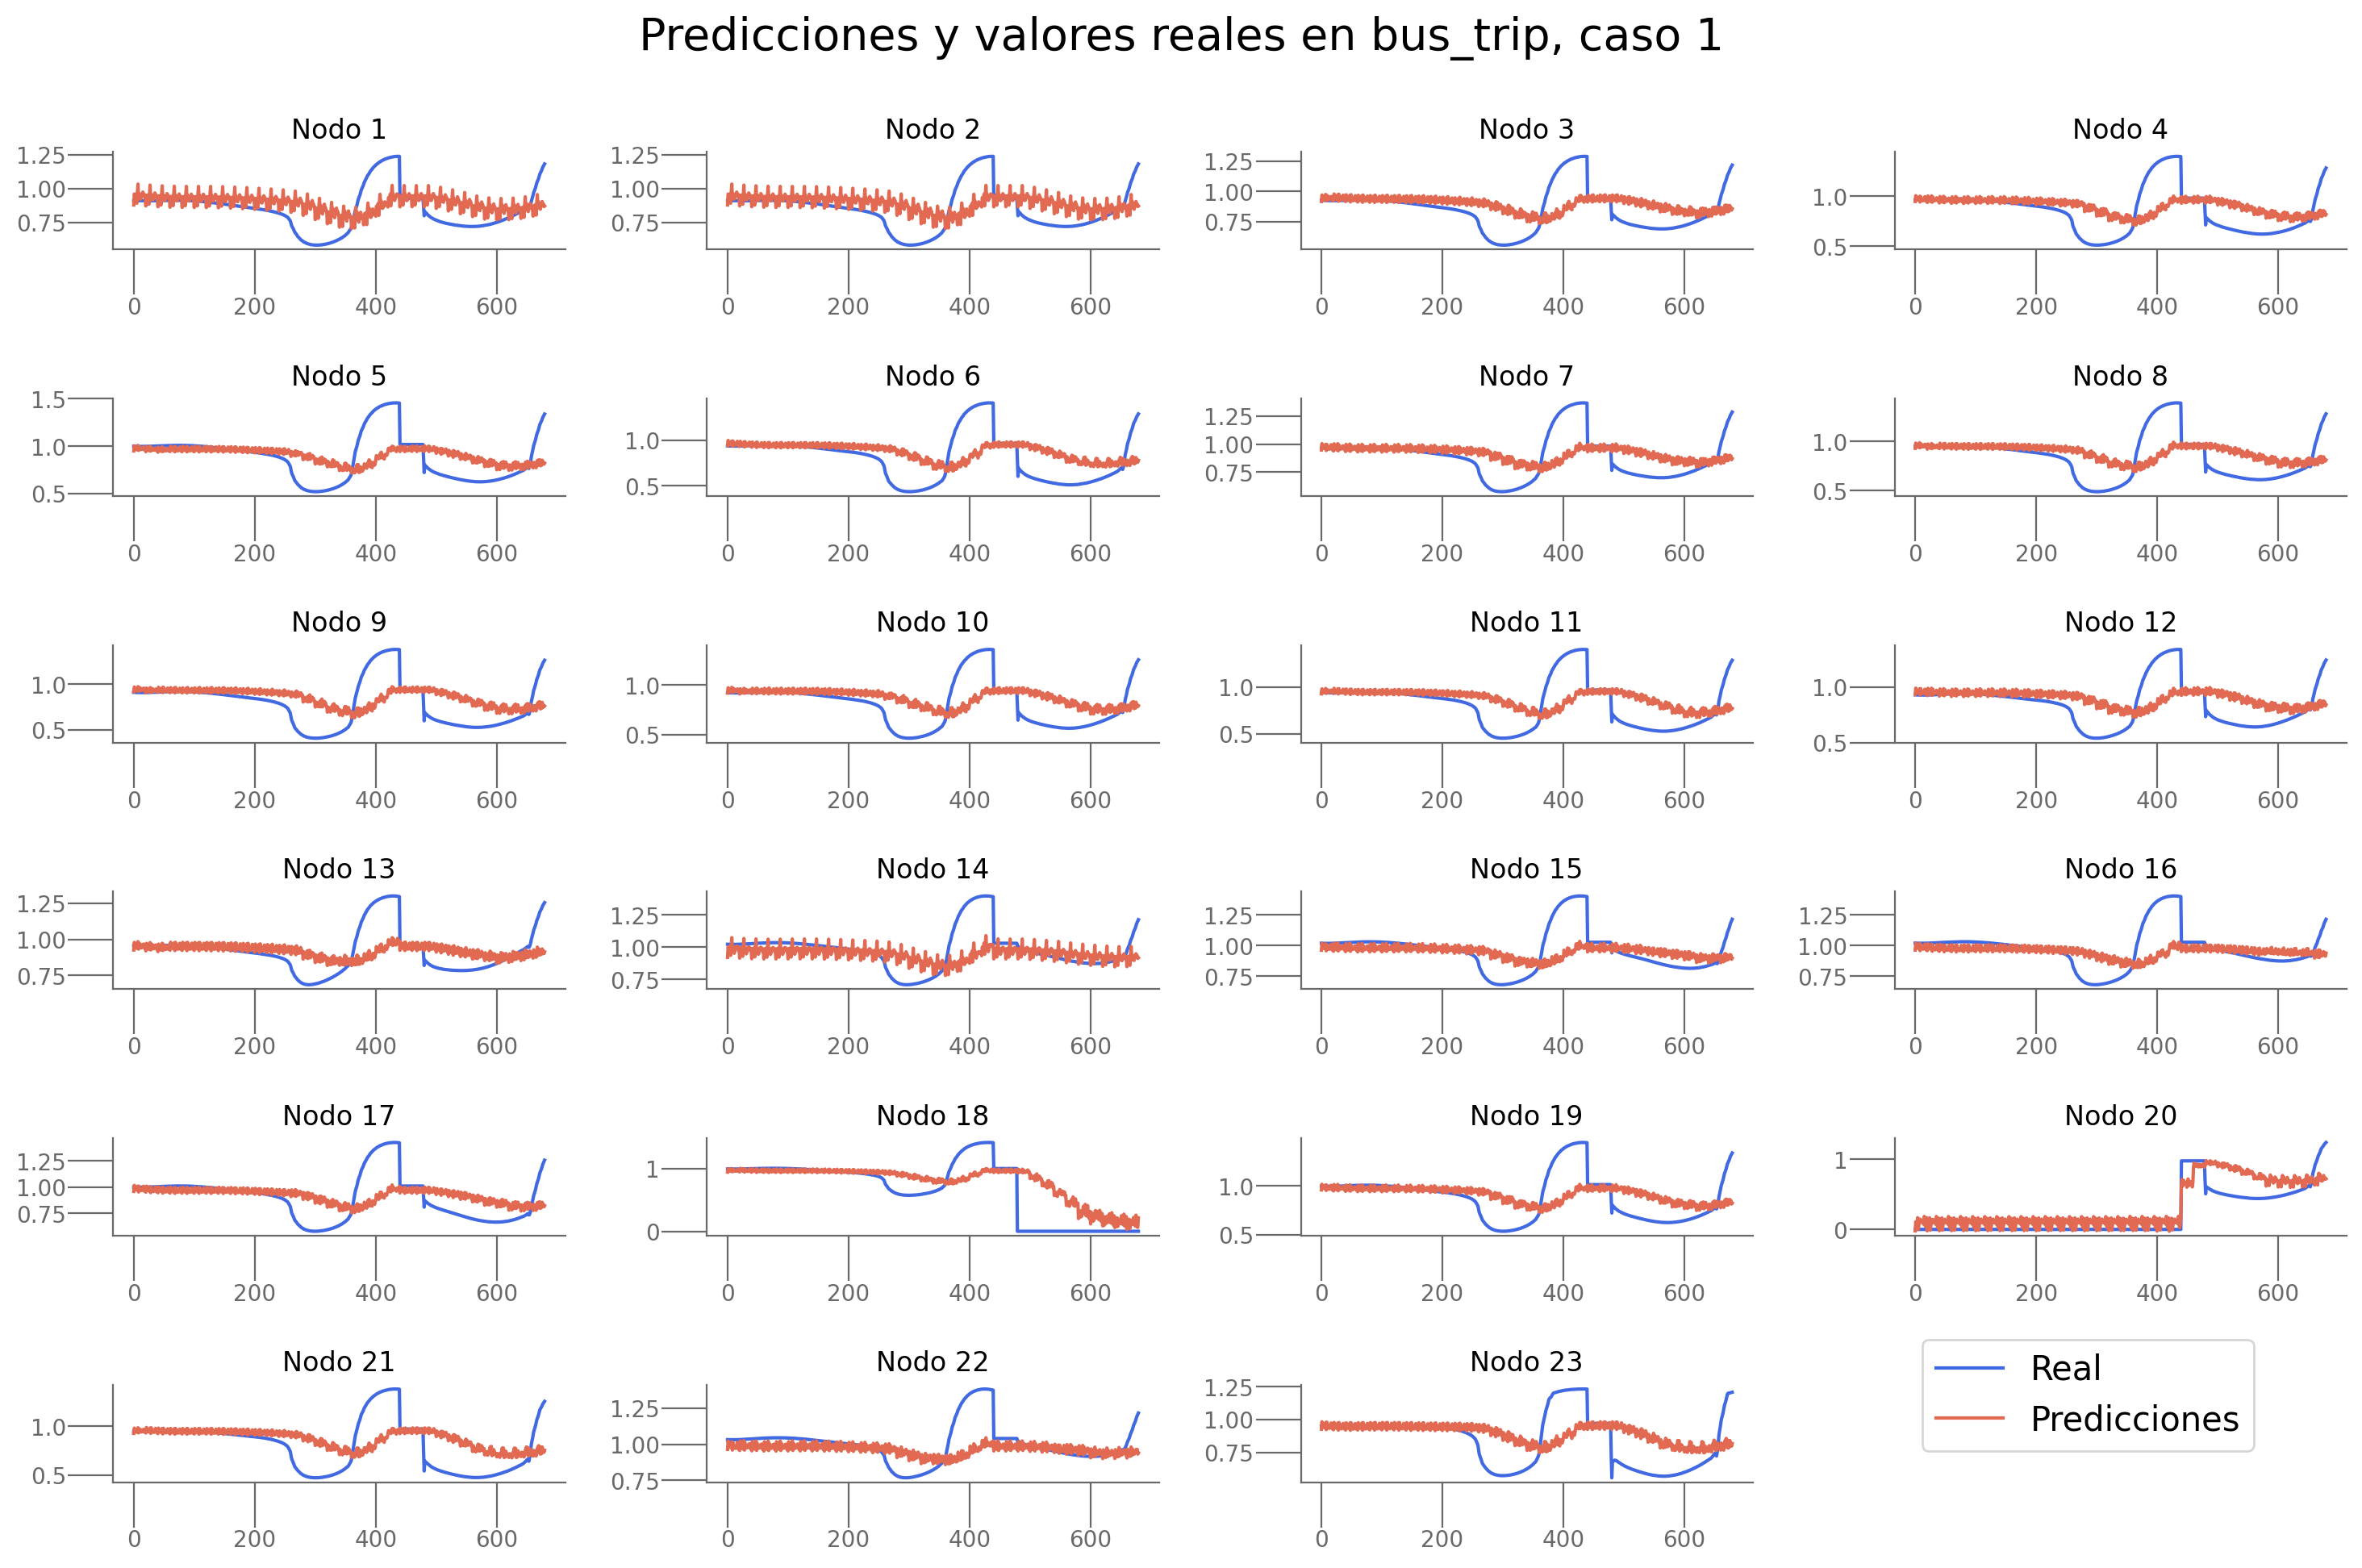

In [30]:
plot_predictions(predictions_bt, real_bt, n_target, 1, n_div_bt, problem)

### Bus fault

In [31]:
problem = "bus_fault"
dataset_bf, situations_bf = loader.get_dataset( target= 20, intro=100, step=20, one_ts_per_situation=False, start = 1, type=problem)




Number of situations:  549
Number of timestamps:  800
Number of situations of the selected type:  86


In [32]:
n_div_bf = loader.div

#### Sencilla 

In [33]:
n_nodes =dataset_bf.features[0].shape[0]
n_target = dataset_bf.targets[0].shape[1]
n_features = dataset_bf[0].x.shape[1]
embedding_dim =5


==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 430

==================== TRAIN INFO ===================

Epoch 1/30 | Train Loss: 1.0047 | Eval Loss: 0.4807 | Eval R2: -13.6091 | LR: 0.010000
Epoch 2/30 | Train Loss: 0.5349 | Eval Loss: 0.1067 | Eval R2: -2.0118 | LR: 0.010000
Epoch 3/30 | Train Loss: 0.1090 | Eval Loss: 0.2048 | Eval R2: -6.0392 | LR: 0.010000
Epoch 4/30 | Train Loss: 0.1845 | Eval Loss: 0.1262 | Eval R2: -3.2557 | LR: 0.010000
Epoch 5/30 | Train Loss: 0.1146 | Eval Loss: 0.0726 | Eval R2: -1.1042 | LR: 0.010000
Epoch 6/30 | Train Loss: 0.0735 | Eval Loss: 0.0763 | Eval R2: -0.9768 | LR: 0.010000
Epoch 7/30 | Train Loss: 0.0875 | Eval Loss: 0.0777 | Eval R2: -0.9775 | LR: 0.010000
Epoch 8/30 | Train Loss: 0.0914 | Eval Loss: 0.0624 | Eval R2: -0.5645 | LR: 0.010000
Epoch 9/30 | Train Loss: 0.0738 | Eval Loss: 0.0480 | Eval R2: -0.2663 | LR: 0.010000
Epoch 10/30 | Train Loss: 0.0553 | Eval Loss: 0.0483 

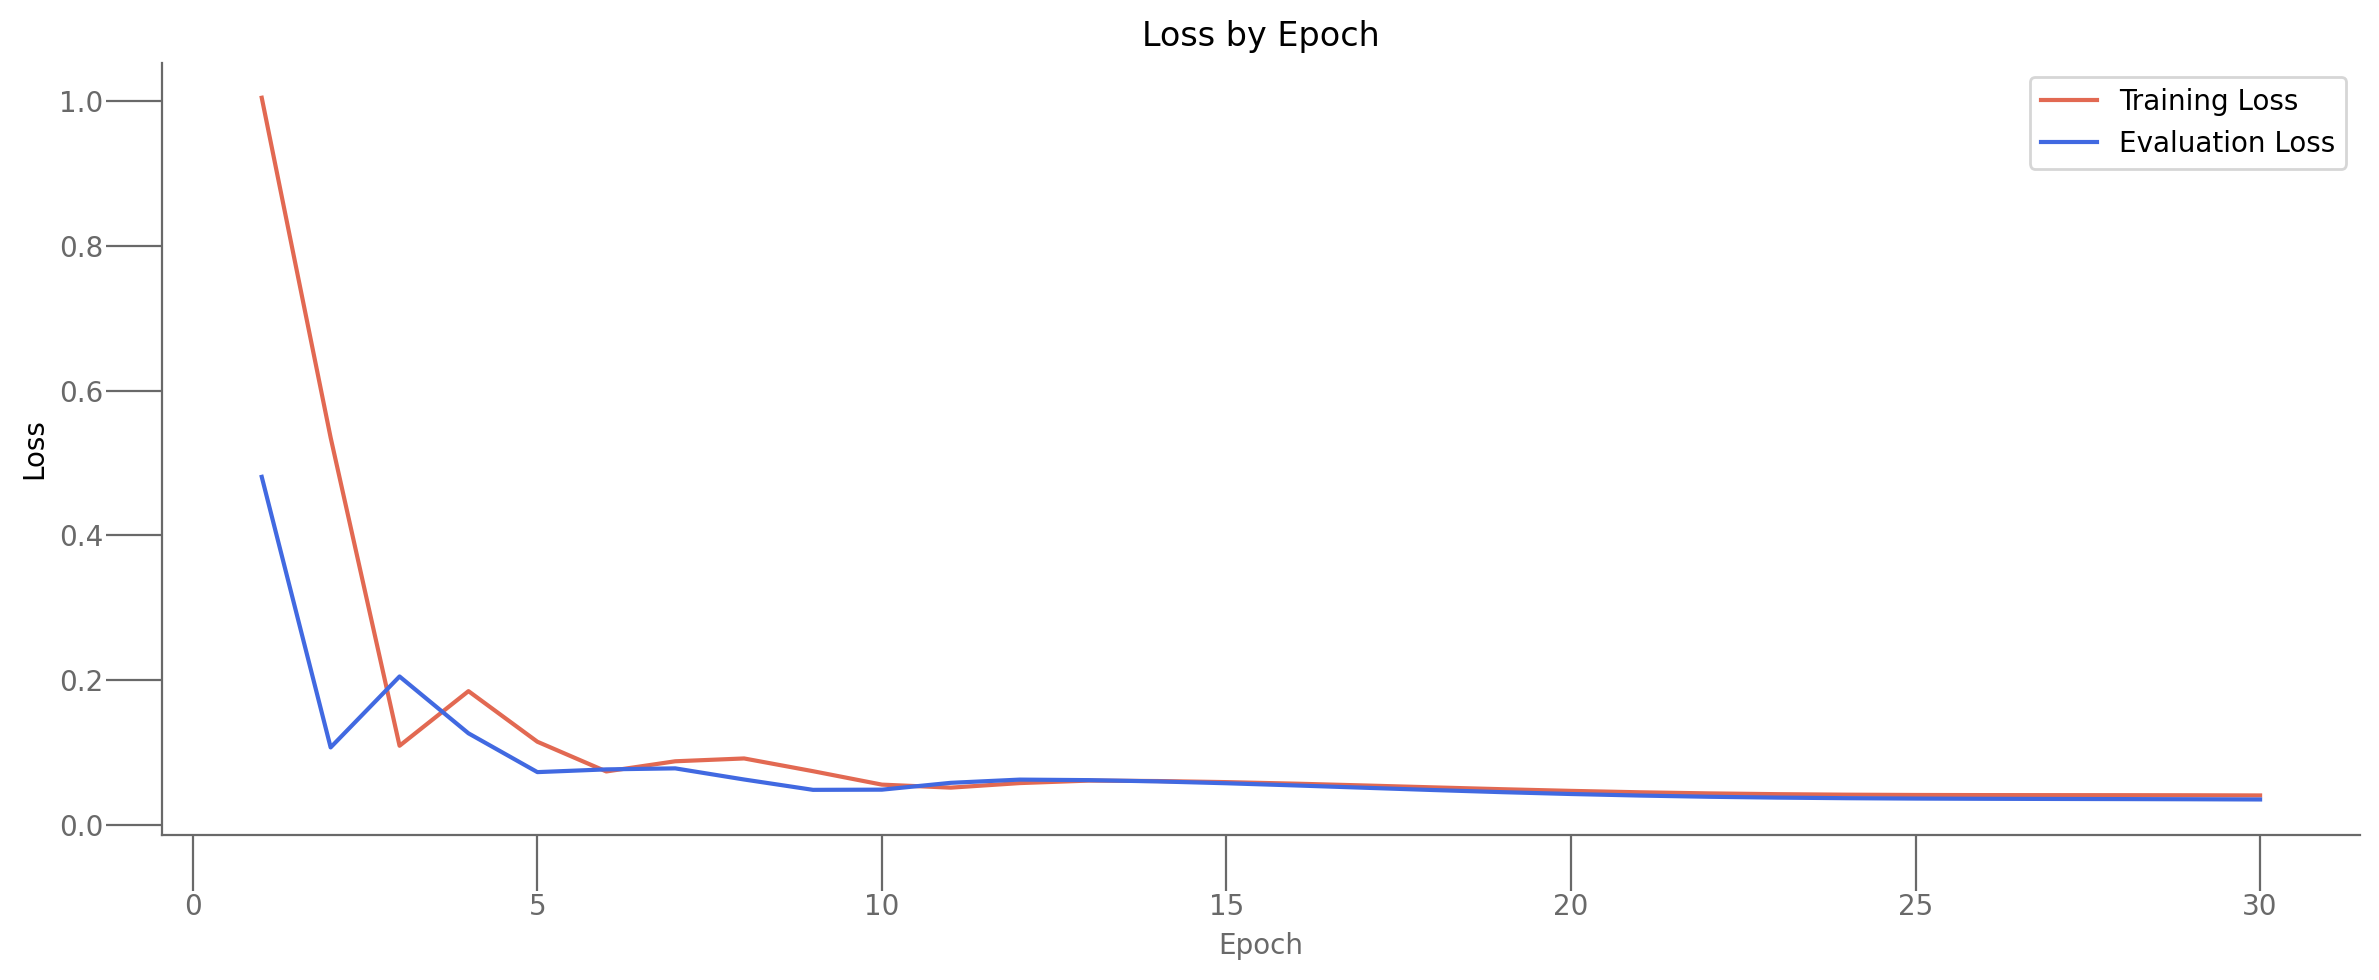


==================== TEST INFO ===================

Test_loss:0.0453, Test_r2:-0.0974


In [34]:

dataloader_bf = trainer.train_test_val_split(dataset_bt, 
                                          batch_size=dataloader_params2["batch_size"], 
                                          data_split_ratio=dataloader_params2["data_split_ratio"], 
                                          random_seed=dataloader_params2["seed"], 
                                          keep_same=dataloader_params2["keep_same"], 
                                          use_batch=dataloader_params2["use_batch"])
model_bf = RecurrentGCN("DyGrEncoder",node_features= n_features, node_count=n_nodes, n_target=n_target, aggr="add")

num_early_stop = 0
num_epochs = 30
lr = 0.01
losses,eval_losses, r2scores, h = train(model_bf, dataloader_bf, num_early_stop, num_epochs, lr)
plot_training_and_eval_losses(np.array(losses), np.array(eval_losses).mean(axis=1), num_epochs, format_plot)
losses_tst, r2score_tst, predictions_bf, real_bf = test(model_bf, dataloader_bf, h)


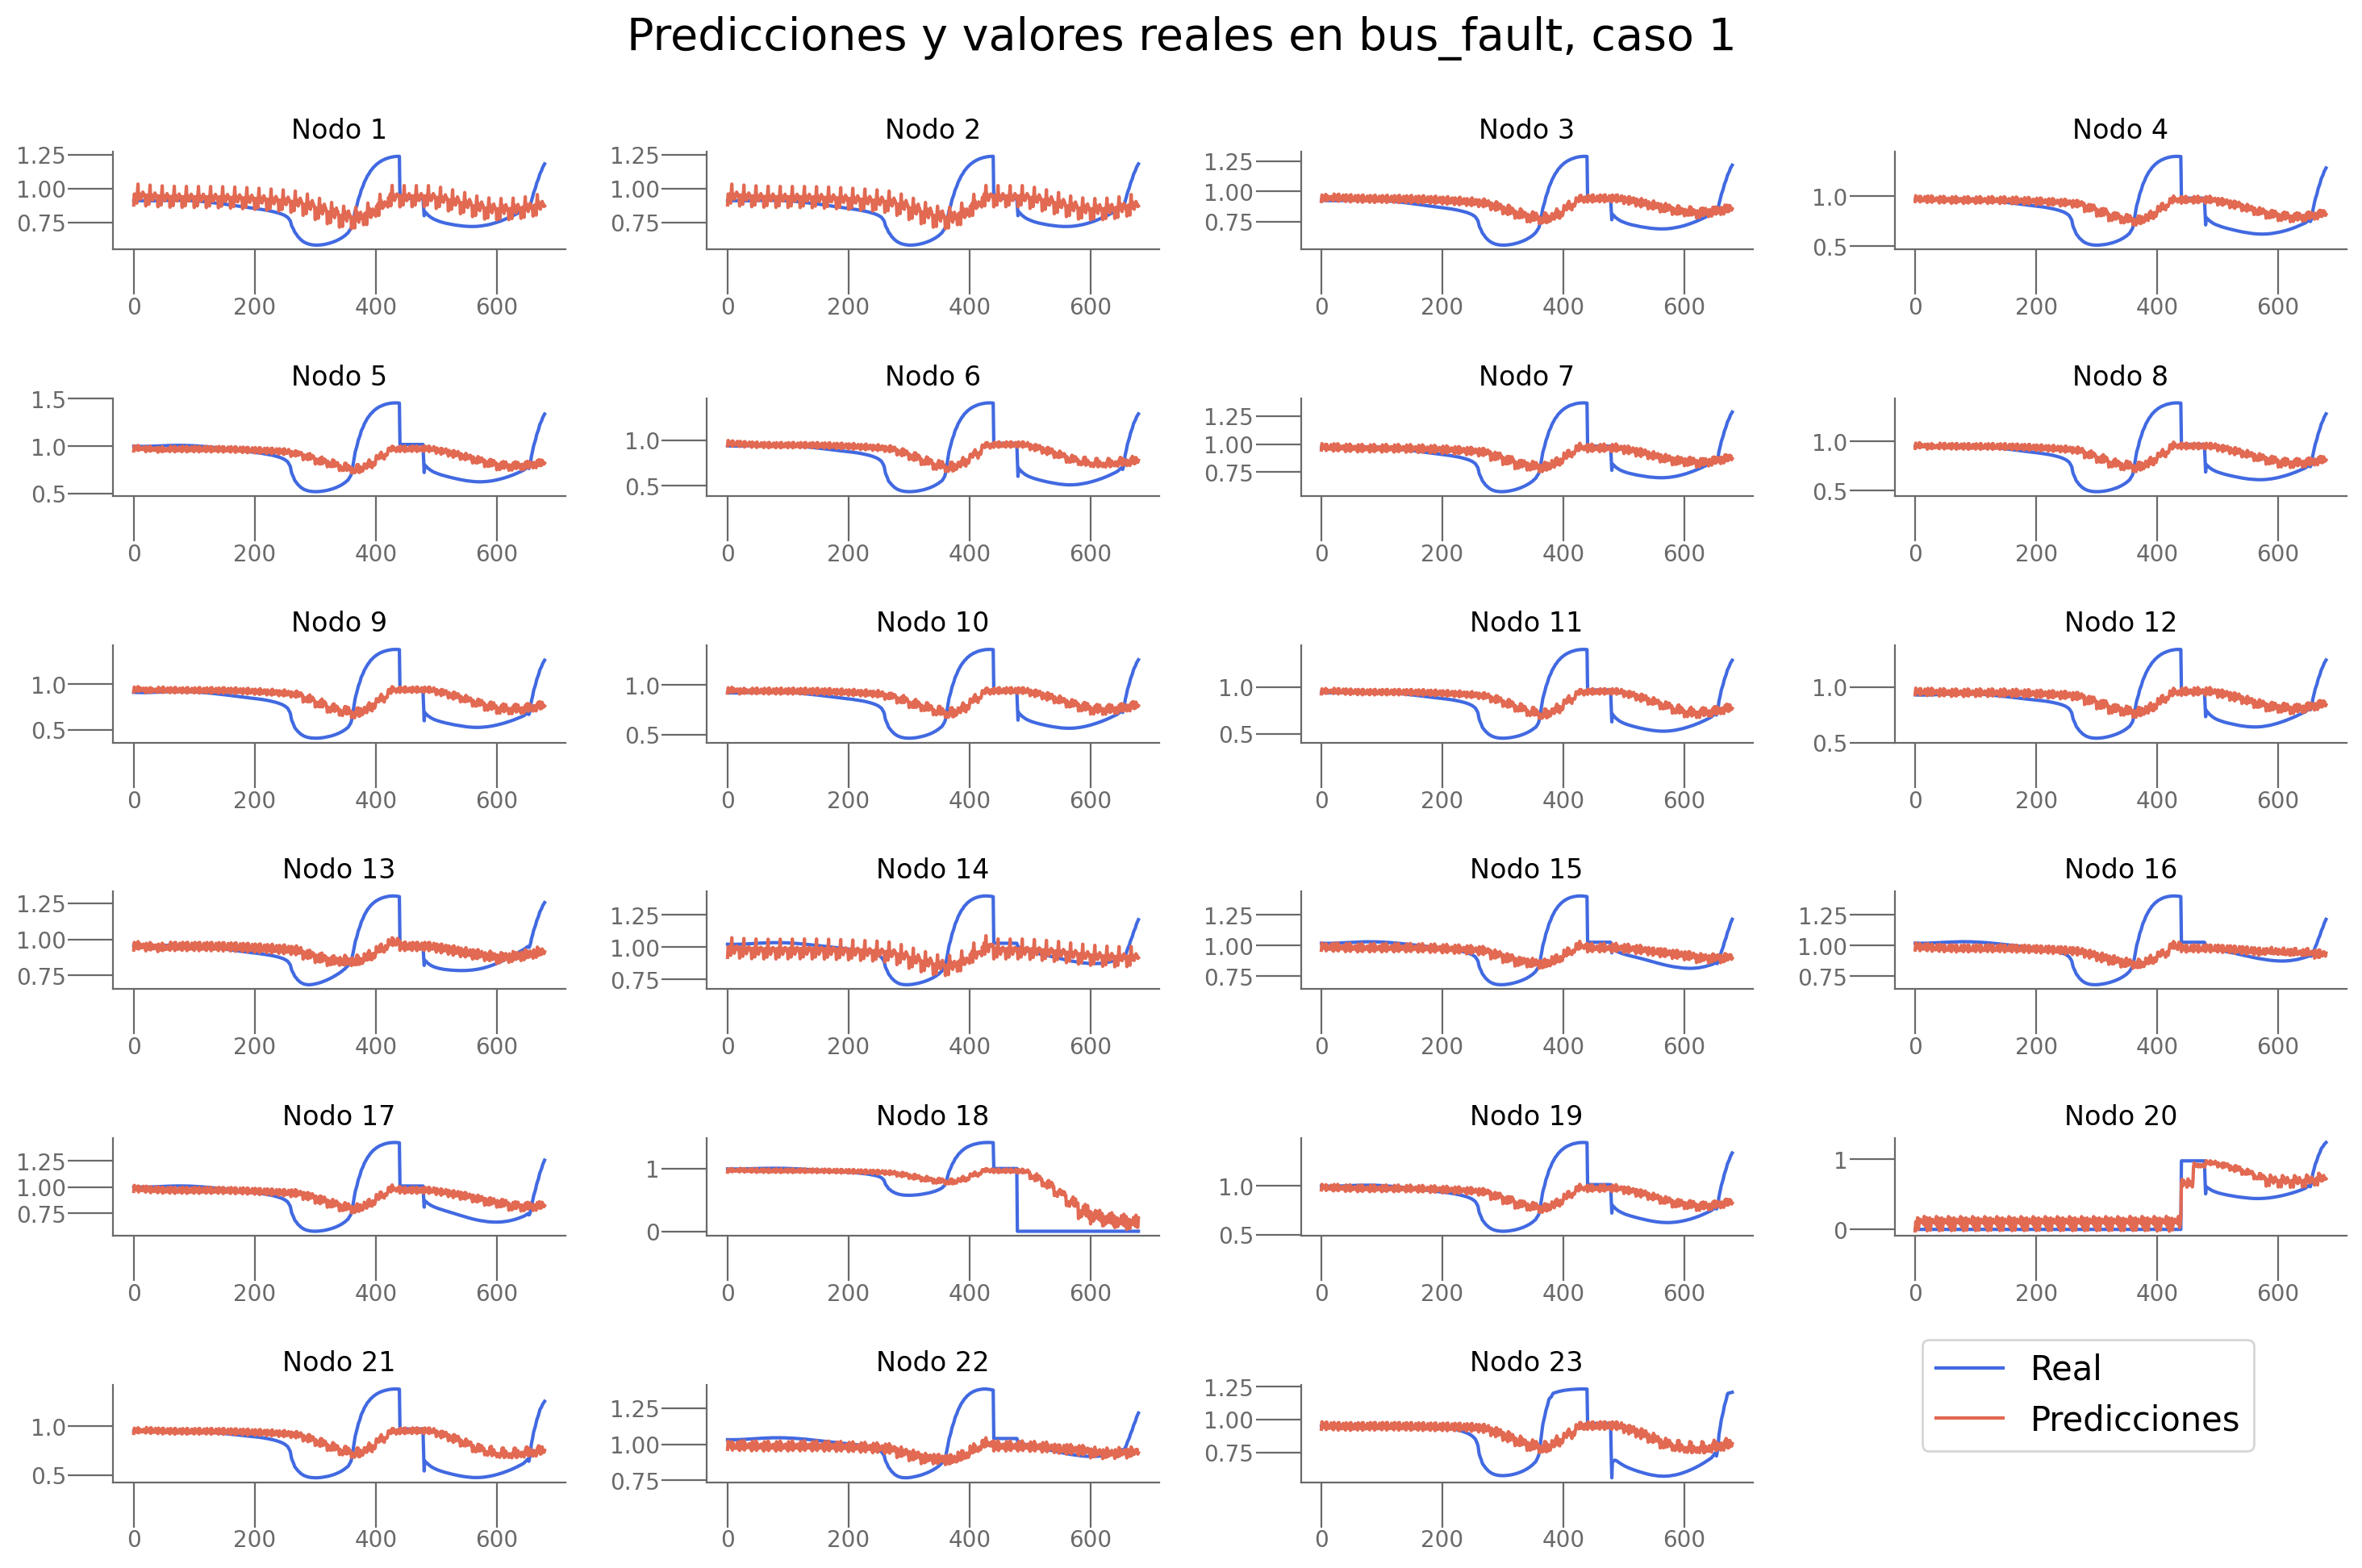

In [36]:
plot_predictions(predictions_bf, real_bf, n_target, 1,n_div_bf, problem)

### Branch Fault

In [37]:
problem = "branch_fault"
dataset_brf, situations_brf = loader.get_dataset( target= 20, intro=100, step=20, one_ts_per_situation=False, start = 1, type=problem)


Number of situations:  549
Number of timestamps:  800
Number of situations of the selected type:  92


In [38]:
n_div_brf = loader.div

#### Sencilla 

In [39]:
n_nodes =dataset_brf.features[0].shape[0]
n_target = dataset_brf.targets[0].shape[1]
n_features = dataset_brf[0].x.shape[1]
embedding_dim =5


==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 430

==================== TRAIN INFO ===================

Epoch 1/30 | Train Loss: 1.0047 | Eval Loss: 0.4807 | Eval R2: -13.6091 | LR: 0.010000
Epoch 2/30 | Train Loss: 0.5349 | Eval Loss: 0.1067 | Eval R2: -2.0118 | LR: 0.010000
Epoch 3/30 | Train Loss: 0.1090 | Eval Loss: 0.2048 | Eval R2: -6.0392 | LR: 0.010000
Epoch 4/30 | Train Loss: 0.1845 | Eval Loss: 0.1262 | Eval R2: -3.2557 | LR: 0.010000
Epoch 5/30 | Train Loss: 0.1146 | Eval Loss: 0.0726 | Eval R2: -1.1042 | LR: 0.010000
Epoch 6/30 | Train Loss: 0.0735 | Eval Loss: 0.0763 | Eval R2: -0.9768 | LR: 0.010000
Epoch 7/30 | Train Loss: 0.0875 | Eval Loss: 0.0777 | Eval R2: -0.9775 | LR: 0.010000
Epoch 8/30 | Train Loss: 0.0914 | Eval Loss: 0.0624 | Eval R2: -0.5645 | LR: 0.010000
Epoch 9/30 | Train Loss: 0.0738 | Eval Loss: 0.0480 | Eval R2: -0.2663 | LR: 0.010000
Epoch 10/30 | Train Loss: 0.0553 | Eval Loss: 0.0483 

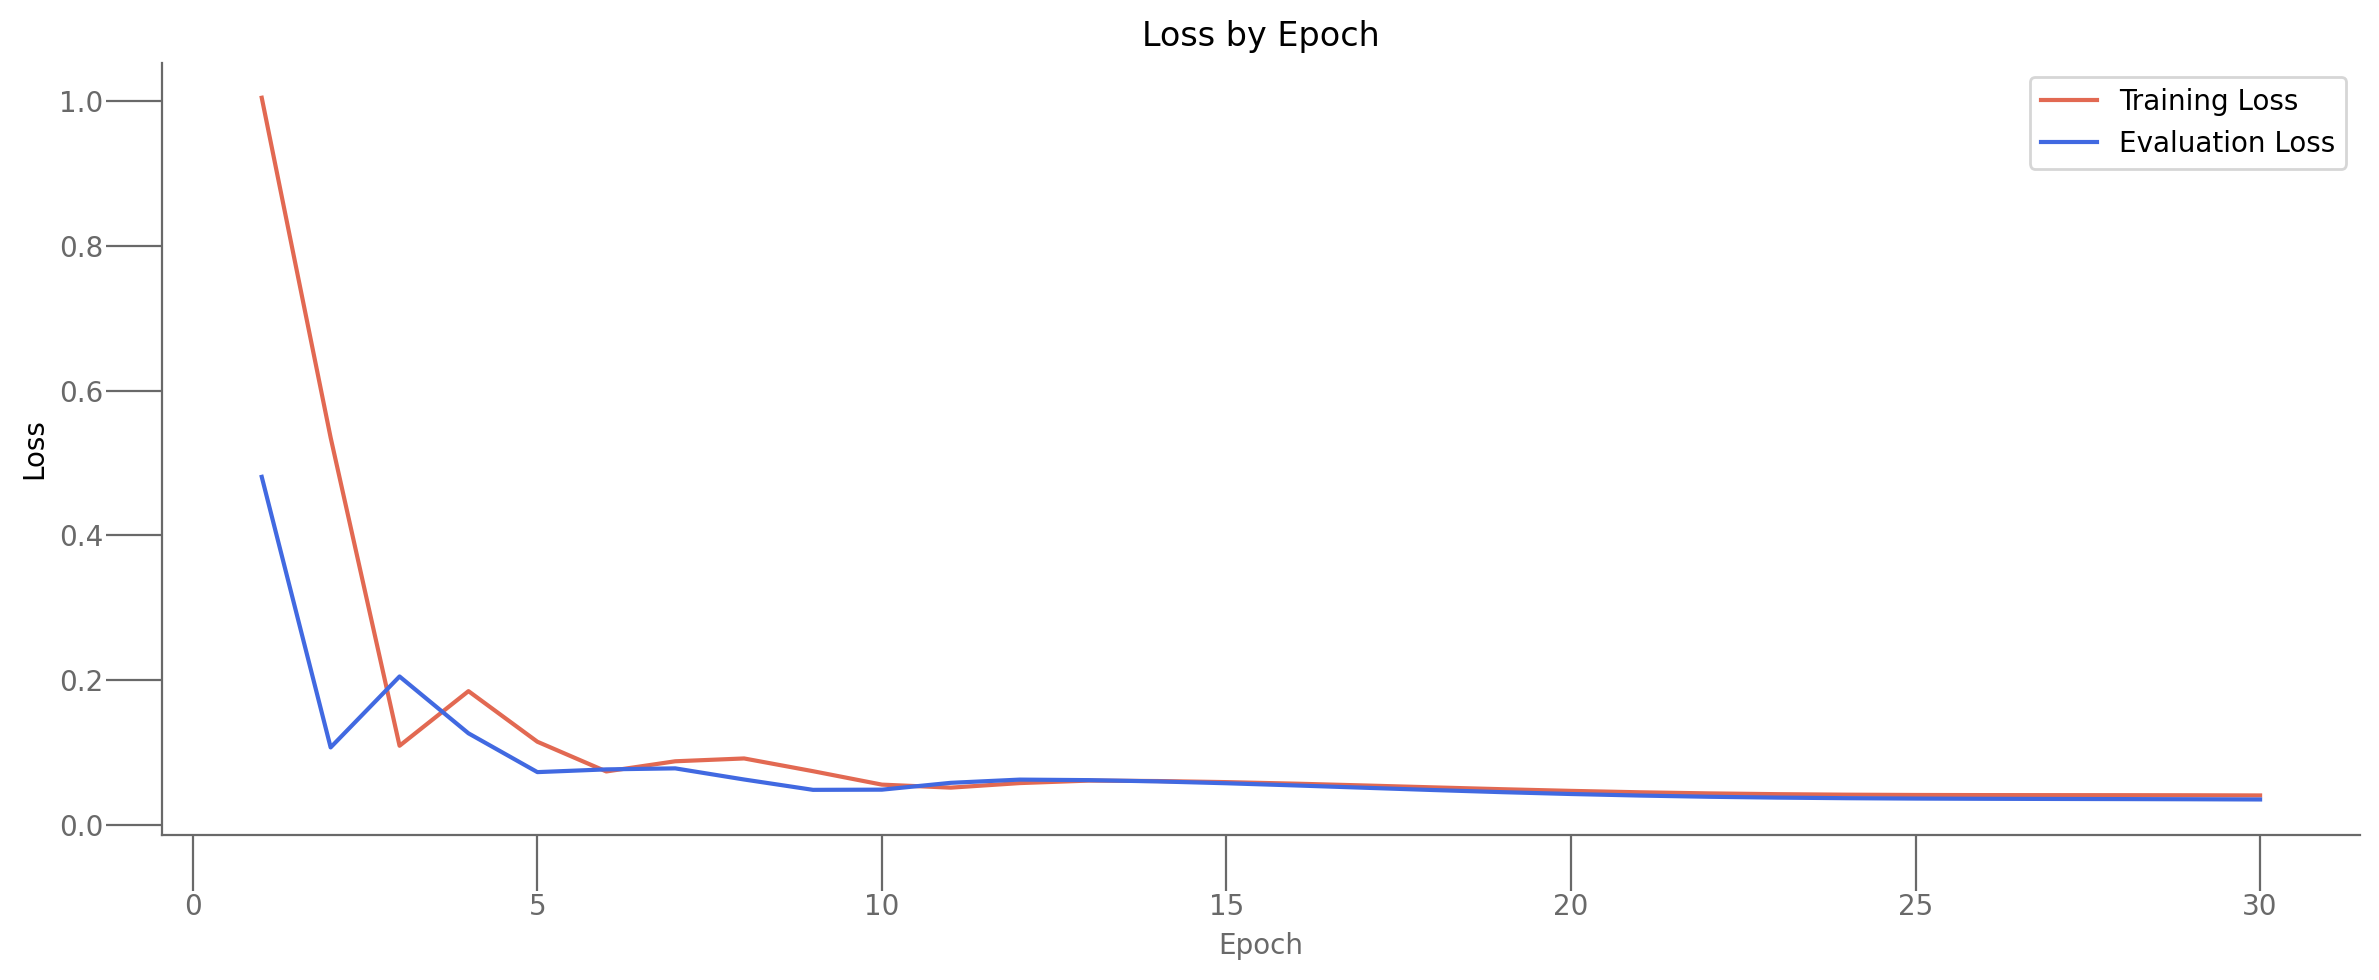


==================== TEST INFO ===================

Test_loss:0.0453, Test_r2:-0.0974


In [40]:
dataloader_brf = trainer.train_test_val_split(dataset_bt, 
                                          batch_size=dataloader_params2["batch_size"], 
                                          data_split_ratio=dataloader_params2["data_split_ratio"], 
                                          random_seed=dataloader_params2["seed"], 
                                          keep_same=dataloader_params2["keep_same"], 
                                          use_batch=dataloader_params2["use_batch"])
model_brf = RecurrentGCN("DyGrEncoder",node_features= n_features, node_count=n_nodes, n_target=n_target, aggr="add")


num_early_stop = 0
num_epochs = 30
lr = 0.01
losses,eval_losses, r2scores, h = train(model_brf, dataloader_brf, num_early_stop, num_epochs, lr)
plot_training_and_eval_losses(np.array(losses), np.array(eval_losses).mean(axis=1), num_epochs, format_plot)
losses_tst, r2score_tst, predictions_brf, real_brf = test(model_brf, dataloader_brf, h)


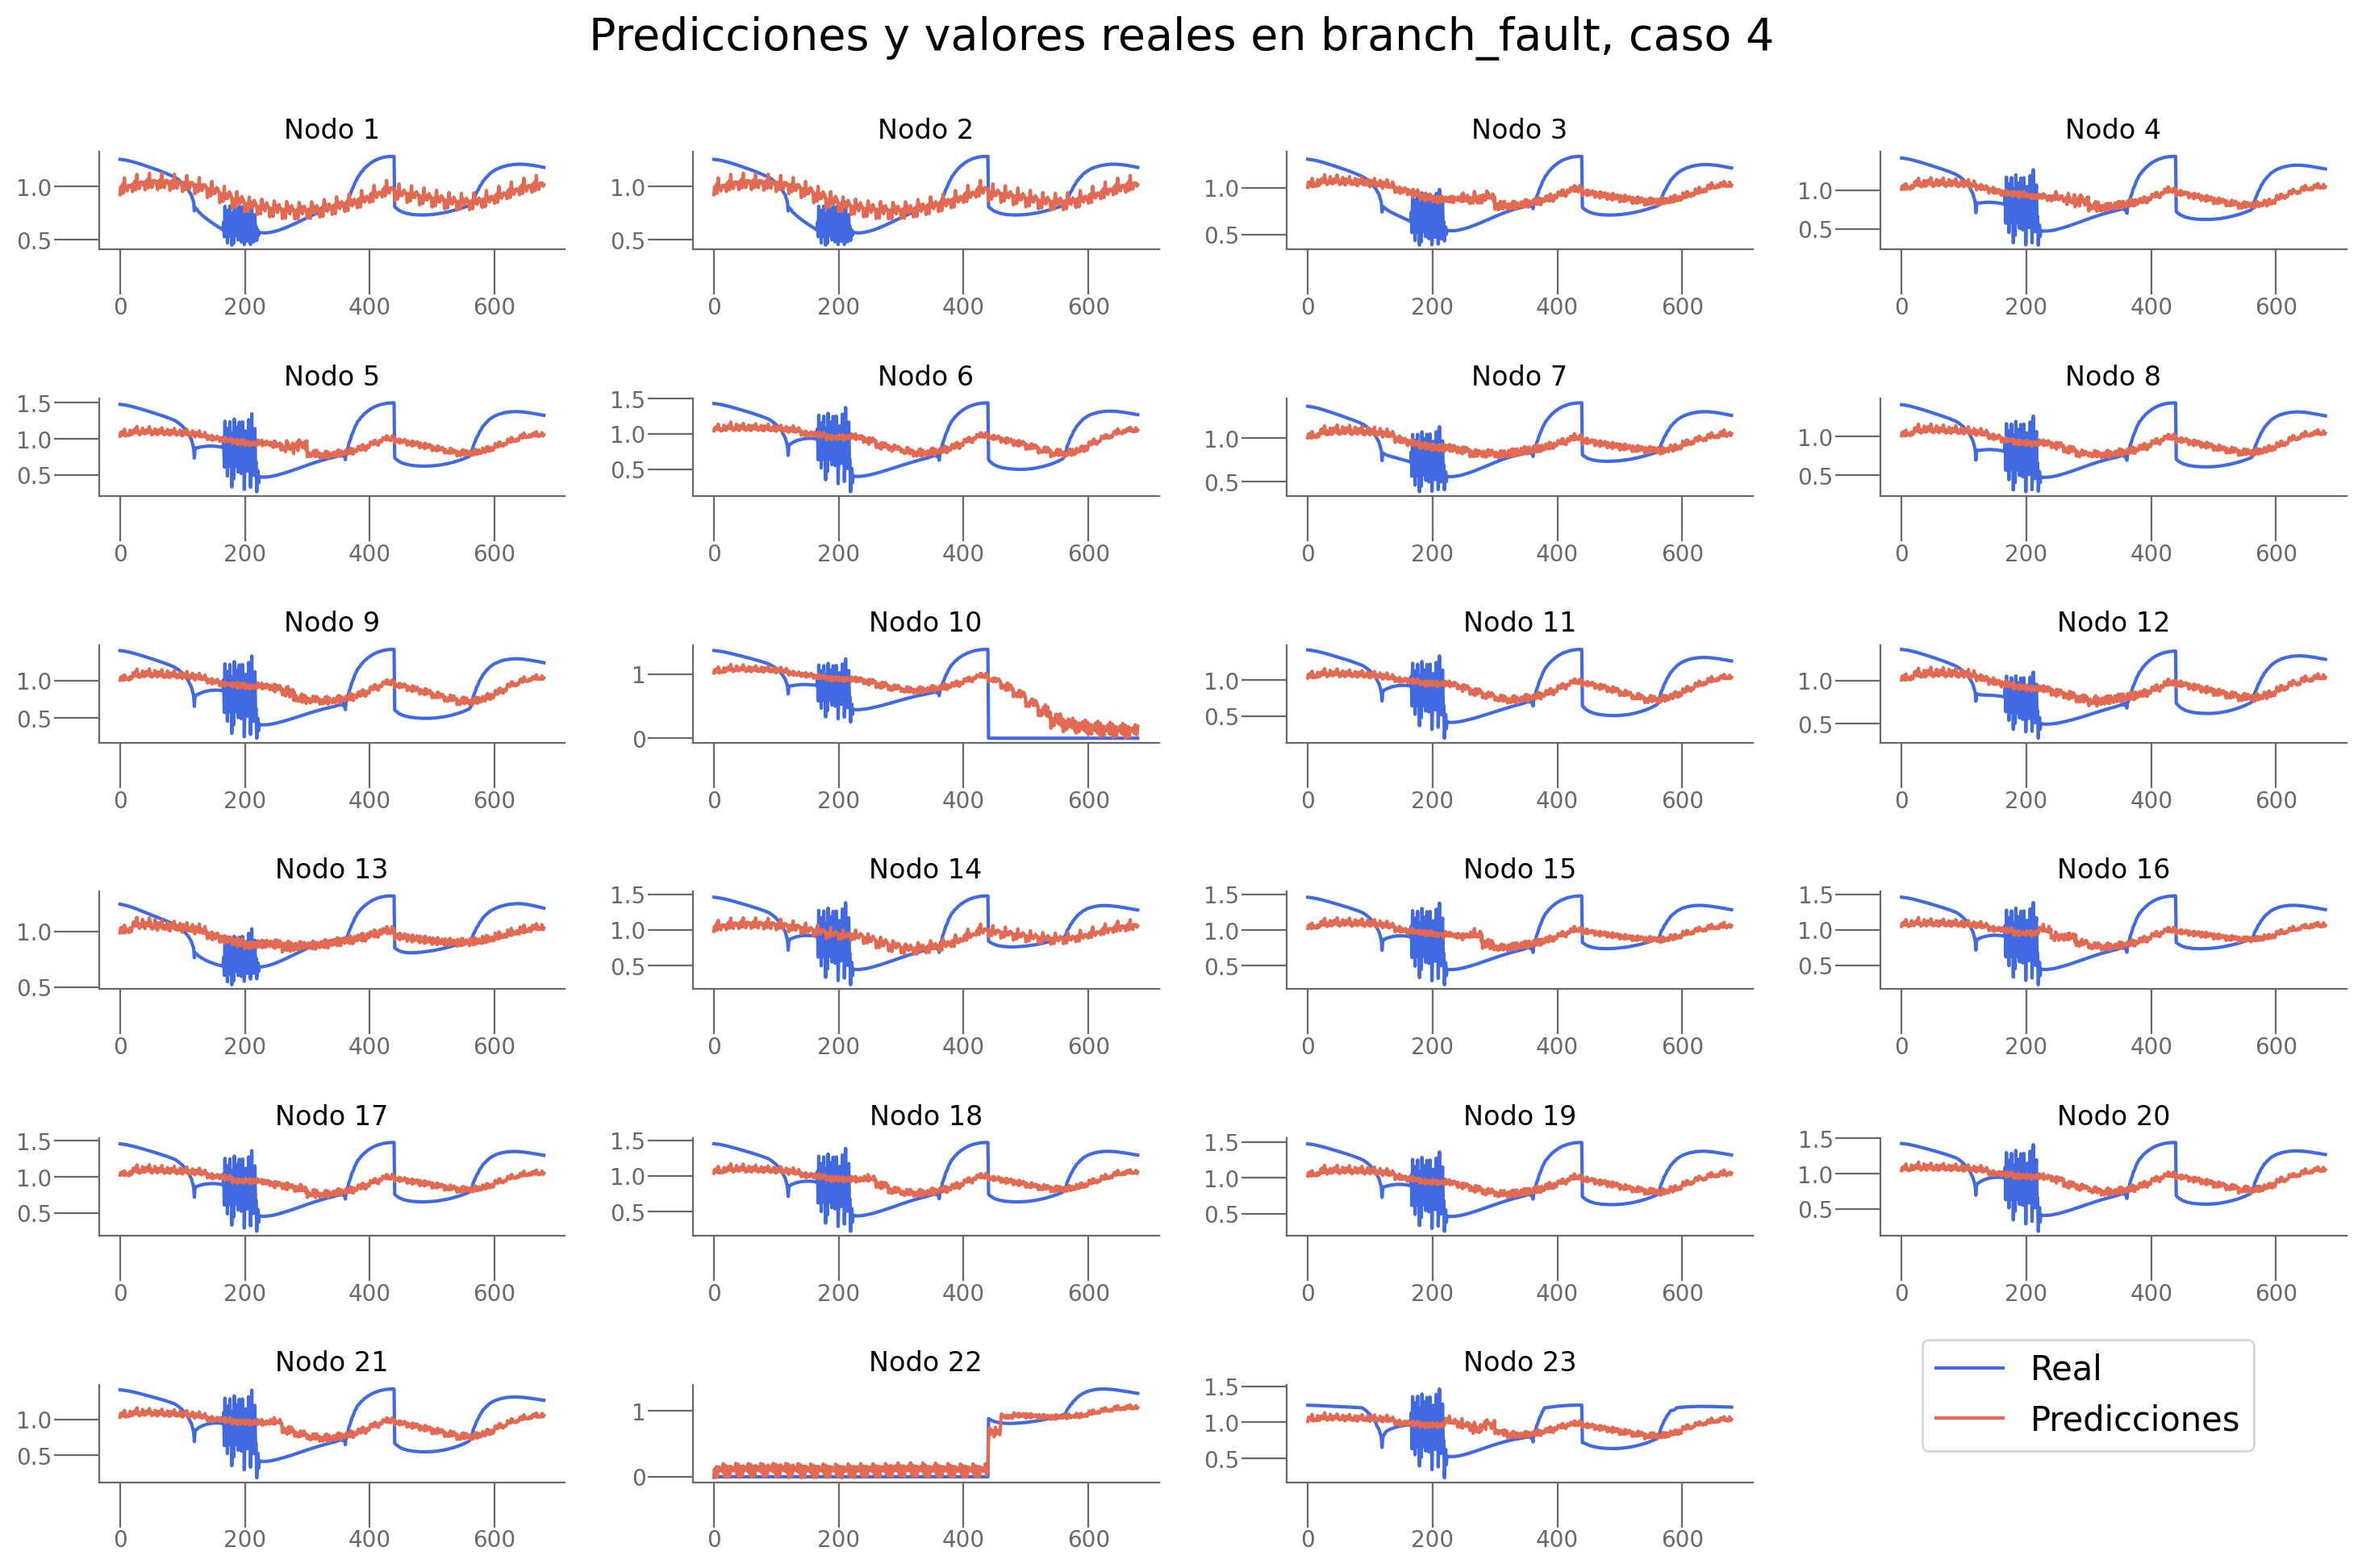

In [41]:
plot_predictions(predictions_brf, real_brf, n_target, 4,  n_div_brf, problem)

### Branch trip

In [42]:
problem = "branch_trip"
dataset_brt, situations_brt = loader.get_dataset( target= 20, intro=100, step=20, one_ts_per_situation=False, start = 1, type=problem)




Number of situations:  549
Number of timestamps:  800
Number of situations of the selected type:  101


In [43]:
n_div_brt = loader.div

#### Sencilla 

In [44]:
n_nodes =dataset_brt.features[0].shape[0]
n_target = dataset_brt.targets[0].shape[1]
n_features = dataset_brt[0].x.shape[1]
embedding_dim =5


==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 430

==================== TRAIN INFO ===================

Epoch 1/30 | Train Loss: 1.0047 | Eval Loss: 0.4807 | Eval R2: -13.6091 | LR: 0.010000
Epoch 2/30 | Train Loss: 0.5349 | Eval Loss: 0.1067 | Eval R2: -2.0118 | LR: 0.010000
Epoch 3/30 | Train Loss: 0.1090 | Eval Loss: 0.2048 | Eval R2: -6.0392 | LR: 0.010000
Epoch 4/30 | Train Loss: 0.1845 | Eval Loss: 0.1262 | Eval R2: -3.2557 | LR: 0.010000
Epoch 5/30 | Train Loss: 0.1146 | Eval Loss: 0.0726 | Eval R2: -1.1042 | LR: 0.010000
Epoch 6/30 | Train Loss: 0.0735 | Eval Loss: 0.0763 | Eval R2: -0.9768 | LR: 0.010000
Epoch 7/30 | Train Loss: 0.0875 | Eval Loss: 0.0777 | Eval R2: -0.9775 | LR: 0.010000
Epoch 8/30 | Train Loss: 0.0914 | Eval Loss: 0.0624 | Eval R2: -0.5645 | LR: 0.010000
Epoch 9/30 | Train Loss: 0.0738 | Eval Loss: 0.0480 | Eval R2: -0.2663 | LR: 0.010000
Epoch 10/30 | Train Loss: 0.0553 | Eval Loss: 0.0483 

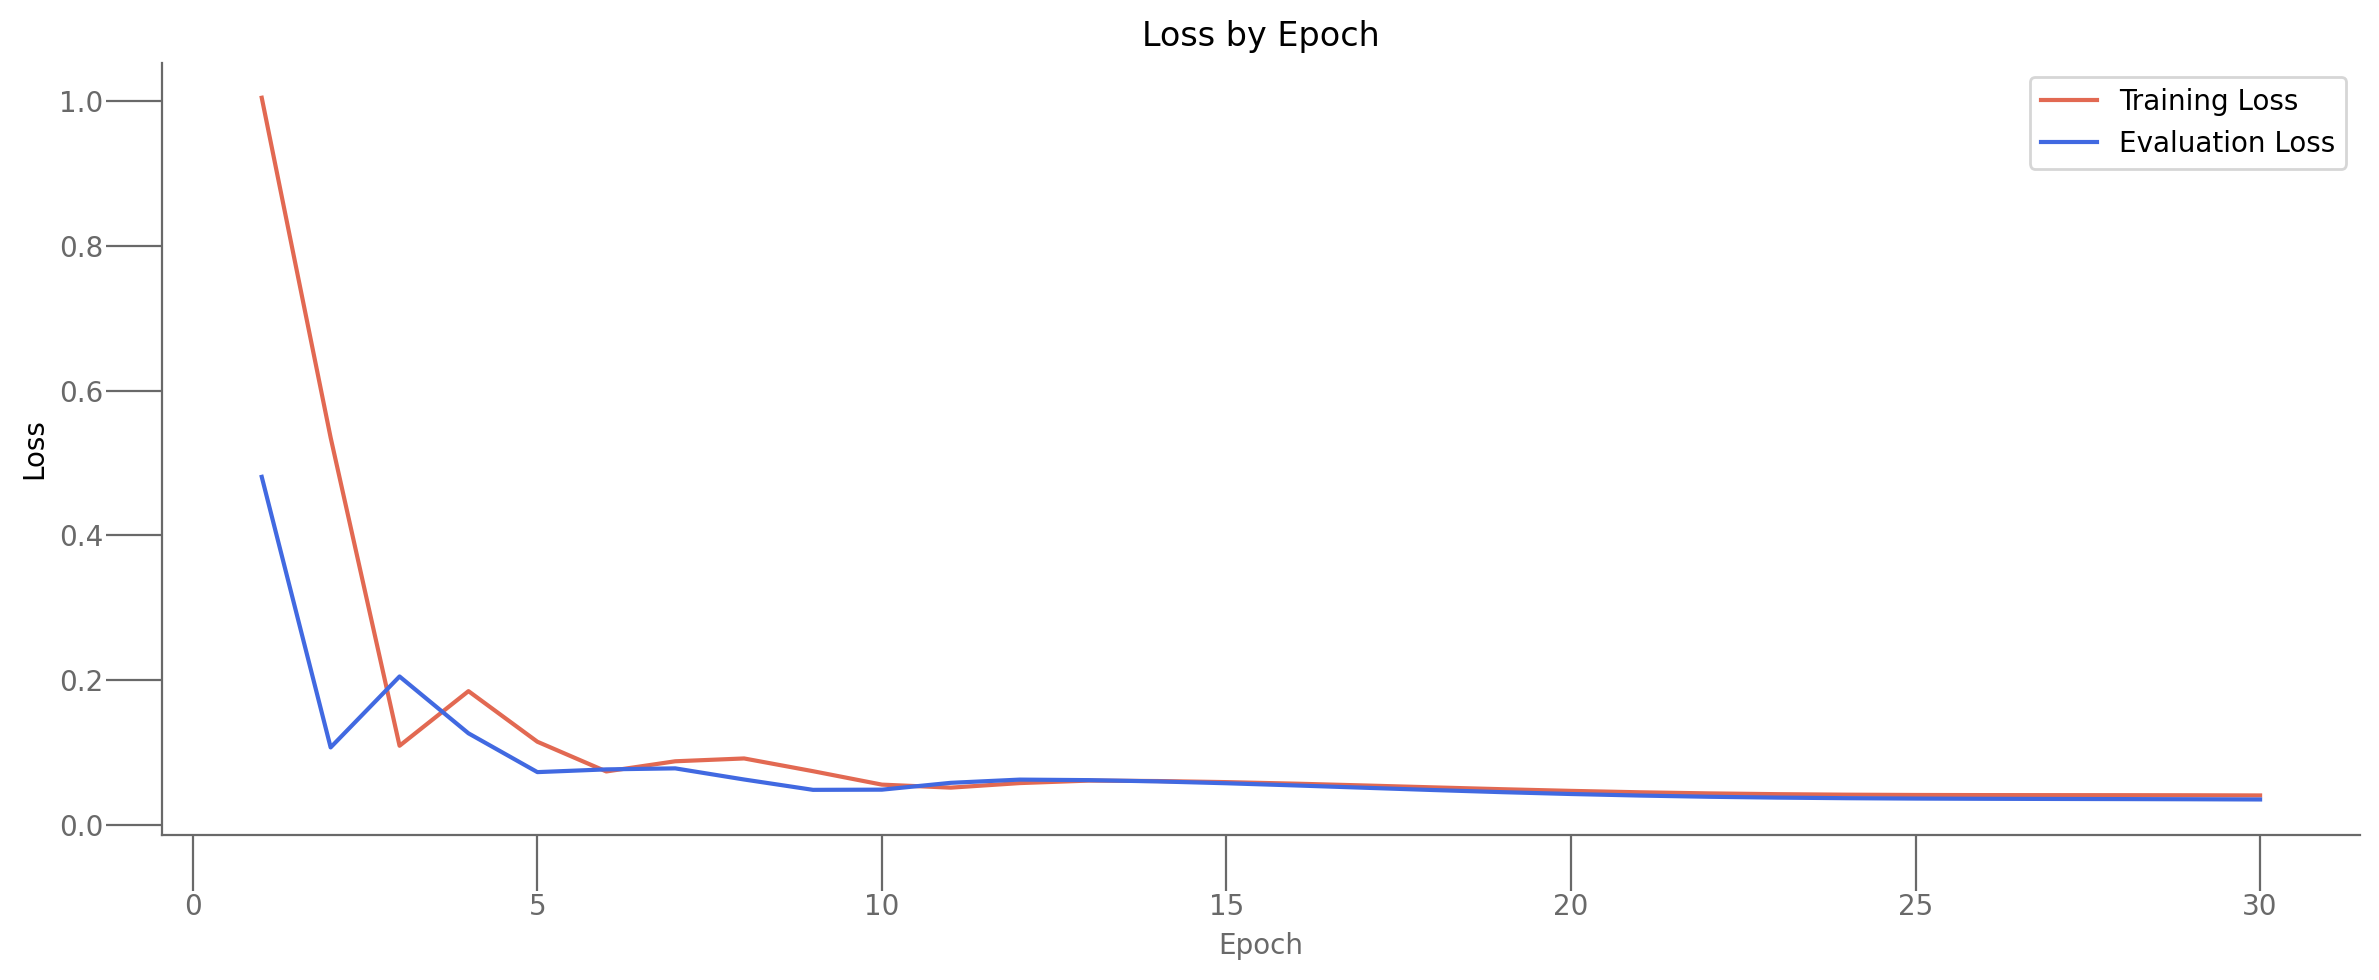


==================== TEST INFO ===================

Test_loss:0.0453, Test_r2:-0.0974


In [45]:

dataloader_brt = trainer.train_test_val_split(dataset_bt, 
                                          batch_size=dataloader_params2["batch_size"], 
                                          data_split_ratio=dataloader_params2["data_split_ratio"], 
                                          random_seed=dataloader_params2["seed"], 
                                          keep_same=dataloader_params2["keep_same"], 
                                          use_batch=dataloader_params2["use_batch"])
model_brt = RecurrentGCN("DyGrEncoder",node_features= n_features, node_count=n_nodes, n_target=n_target, aggr="add")

num_early_stop = 0
num_epochs = 30
lr = 0.01
losses,eval_losses, r2scores, h = train(model_brt, dataloader_brt, num_early_stop, num_epochs, lr)
plot_training_and_eval_losses(np.array(losses), np.array(eval_losses).mean(axis=1), num_epochs, format_plot)
losses_tst, r2score_tst, predictions_brt, real_brt = test(model_brt, dataloader_brt, h)


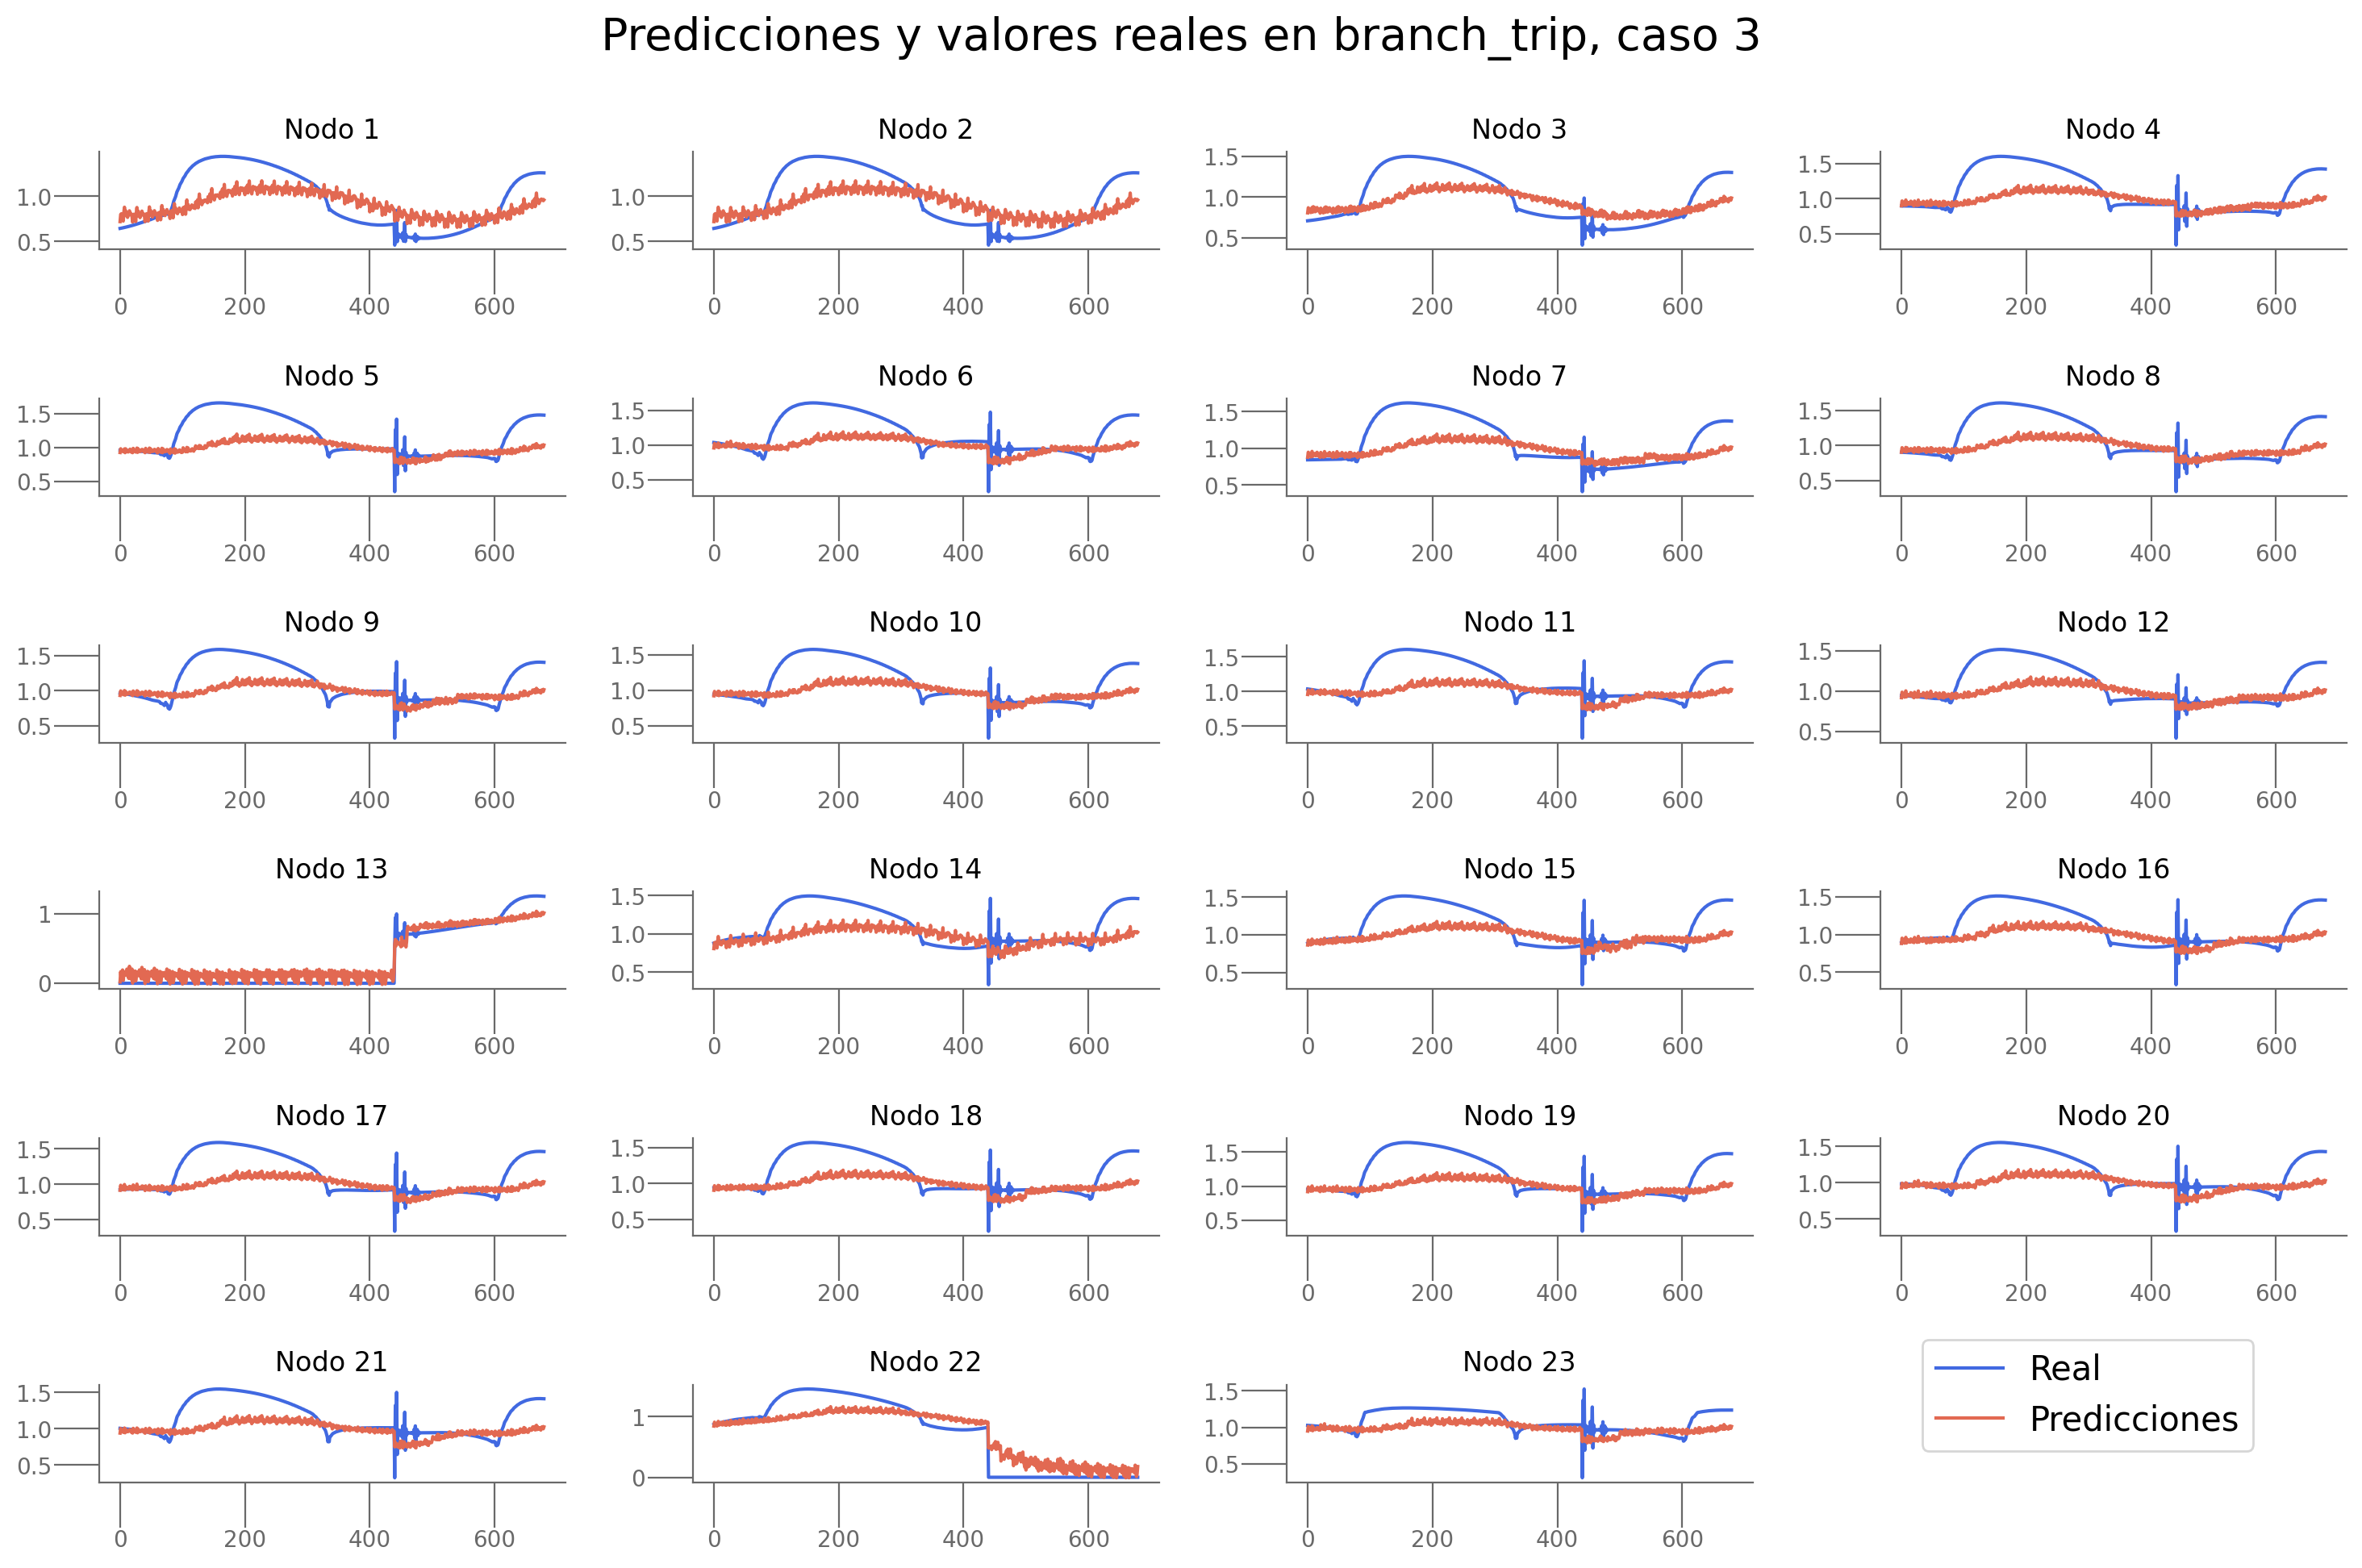

In [46]:
plot_predictions(predictions_brt, real_brt, n_target, 3, n_div_brt, problem)